<center style="font-weight: bold; font-size: 35px">
Predicting Age Through Protein Analysis
</center>
<img src="https://i0.wp.com/www.strengthlog.com/wp-content/uploads/2023/02/functions-of-protein.jpg?resize=700%2C525&ssl=1" alt="Protien Diagram" width="500px" height="400px">

---
## Project Summary

### Goal:
Using past data from plasma protein composition dataset and age of animals to predict how protein changes with aging. There is a higher risk for older patients for many chronic diseases and in order to curate treatments and therapies, it is essential to identify important genes and protein biomarkers that causes this phenotype. For example, it is well known that certain proteins like C-reactive protein and certain growth-differentiation factors are increased with aging (<a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388926/'>link</a>)

### Metrics:
I will be testing the data against a classification and regression estimator (supervised learning) and seeing which are the more suitable model for this experiment. 

The models that I will be testing for classification are:
1. LogisticRegression
2. RandomForestClassification
3. SVC
4. XGBoostClassifier

The models that I will be testing for regression are:
1. SVR
2. RandomForestRegressor
3. LinearRegression
4. KNN
5. XGBoostRegressor
---

### Table of Contents
1. [Data Cleaning and Wrangling](#prelimdata) 
2. [Exploring Data](#eda)
3. [Clustering Analysis](#cluster)
* 3.1 [KMeans](#kmeans)
* 3.2 [PCA Analysis](#pca)

4. [Modeling: Predicting Age](#predict)
* 4.1 [Classification](#classifier)
* 4.2 [Regression](#regressor)
5. [Summary](#summary)
    
### Next Steps:
1. Use the LDA analysis method but on a dataset where the ages have not been reduced to two classes 

In [1]:
# importing the libraries
import pandas as pd
from scipy.stats import shapiro, ttest_ind
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing processing functions from utilities file
from Utils import processing_tools as pt

# importing sklearn processing tools
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans
from sklearn.feature_selection import f_regression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

%matplotlib inline
plt.rcParams['font.family'] = ['Century Gothic']

import warnings
warnings.filterwarnings('ignore')

# 1. Data Cleaning and Wrangling <a name='prelimdata'></a>
Here we import the raw data and make sure it is structured correctly for analysis
1. Imputing Data
2. Missing Values and other Anomaly Detection

`all_panels.csv` is a file that was derived from an aging experiment while the `t_cell_panels.csv` is the compilation of inflammatory proteins in various aged mice for predicting age.
So, I will be using the `all_panels.csv` file for classifying aged vs young plasma proteome while the `t_cell_panels.csv` will be used for regression and predicting age.

In [2]:
# importing main data
df_main = pd.read_csv('all_panels.csv')

In [3]:
df_main.head()

,ID,treatment,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,...,protein_21,protein_22,protein_23,protein_24,protein_25,protein_26,protein_27,protein_28,protein_29,protein_30
0,mouse_1,3,425.83,95.05,2.25,0.80,4.91,6.01,1.12,0.35,...,NaN,18.46,8.84,22.32,62.50,34.43,160.00,21.35,NaN,0.70
1,mouse_2,3,386.18,250.71,3.22,3.20,6.40,4.88,0.09,2.17,...,93.00,91.86,5.30,34.23,86.50,66.38,114.86,43.04,NaN,1.36
2,mouse_3,3,530.66,180.41,6.15,3.70,4.22,4.14,2.78,0.70,...,401.98,45.54,3.92,20.67,141.29,126.12,170.92,33.52,6.12,0.85
3,mouse_4,3,390.91,141.88,2.09,3.70,6.80,9.76,0.49,0.35,...,283.06,18.46,9.75,25.13,67.93,56.07,181.68,15.18,6.60,1.26
4,mouse_5,3,273.75,508.31,4.36,4.72,2.24,7.20,1.28,0.16,...,65.77,62.34,9.29,18.13,77.74,82.05,91.55,21.35,11.11,1.03


In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          56 non-null     object 
 1   treatment   56 non-null     int64  
 2   protein_1   56 non-null     float64
 3   protein_2   56 non-null     float64
 4   protein_3   32 non-null     float64
 5   protein_4   54 non-null     float64
 6   protein_5   56 non-null     float64
 7   protein_6   55 non-null     float64
 8   protein_7   51 non-null     float64
 9   protein_8   49 non-null     float64
 10  protein_9   56 non-null     float64
 11  protein_10  56 non-null     float64
 12  protein_11  52 non-null     float64
 13  protein_12  56 non-null     float64
 14  protein_13  55 non-null     float64
 15  protein_14  53 non-null     float64
 16  protein_15  56 non-null     float64
 17  protein_16  54 non-null     float64
 18  protein_17  51 non-null     float64
 19  protein_18  56 non-null     flo

In [5]:
df_main.isna().sum().sort_values(ascending = False) / len(df_main)

protein_3     0.428571
protein_26    0.178571
protein_29    0.142857
protein_8     0.125000
protein_21    0.107143
protein_7     0.089286
protein_17    0.089286
protein_11    0.071429
protein_20    0.053571
protein_14    0.053571
protein_4     0.035714
protein_16    0.035714
protein_27    0.017857
protein_6     0.017857
protein_13    0.017857
protein_22    0.017857
protein_28    0.000000
protein_25    0.000000
protein_24    0.000000
protein_23    0.000000
ID            0.000000
protein_15    0.000000
protein_19    0.000000
protein_18    0.000000
treatment     0.000000
protein_12    0.000000
protein_10    0.000000
protein_9     0.000000
protein_5     0.000000
protein_2     0.000000
protein_1     0.000000
protein_30    0.000000
dtype: float64

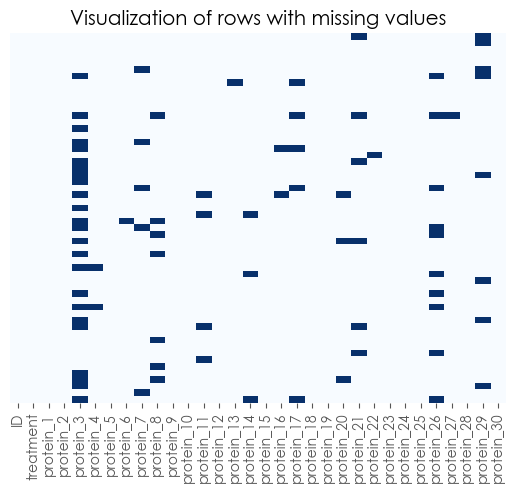

In [6]:
sns.heatmap(df_main.isna(), yticklabels=False, cmap = 'Blues', cbar=None)
plt.title('Visualization of rows with missing values');

Due to the excessive missing values in the IFNy I will remove this column (along with MIP-1B, TNFa, IL-4, and LIX)

In [7]:
# removing whitespace from the column names
df_tmp = df_main.copy()
df_tmp.columns = df_tmp.columns.str.strip()    

In [8]:
df_tmp.columns

Index(['ID', 'treatment', 'protein_1', 'protein_2', 'protein_3', 'protein_4',
       'protein_5', 'protein_6', 'protein_7', 'protein_8', 'protein_9',
       'protein_10', 'protein_11', 'protein_12', 'protein_13', 'protein_14',
       'protein_15', 'protein_16', 'protein_17', 'protein_18', 'protein_19',
       'protein_20', 'protein_21', 'protein_22', 'protein_23', 'protein_24',
       'protein_25', 'protein_26', 'protein_27', 'protein_28', 'protein_29',
       'protein_30'],
      dtype='object')

In [11]:
df_tmp.drop(columns=['protein_3', 'protein_26', 'protein_29', 'protein_8', 'protein_21'], inplace = True, axis = 1)

In [12]:
df_tmp.head()

,ID,treatment,protein_1,protein_2,protein_4,protein_5,protein_6,protein_7,protein_9,protein_10,...,protein_18,protein_19,protein_20,protein_22,protein_23,protein_24,protein_25,protein_27,protein_28,protein_30
0,mouse_1,3,425.83,95.05,0.80,4.91,6.01,1.12,5.55,20.75,...,89.69,212.07,0.50,18.46,8.84,22.32,62.50,160.00,21.35,0.70
1,mouse_2,3,386.18,250.71,3.20,6.40,4.88,0.09,7.86,6.62,...,82.35,227.08,4.54,91.86,5.30,34.23,86.50,114.86,43.04,1.36
2,mouse_3,3,530.66,180.41,3.70,4.22,4.14,2.78,6.52,7.16,...,89.59,99.11,0.03,45.54,3.92,20.67,141.29,170.92,33.52,0.85
3,mouse_4,3,390.91,141.88,3.70,6.80,9.76,0.49,10.67,3.70,...,95.85,85.32,0.82,18.46,9.75,25.13,67.93,181.68,15.18,1.26
4,mouse_5,3,273.75,508.31,4.72,2.24,7.20,1.28,3.35,8.80,...,81.79,73.68,12.11,62.34,9.29,18.13,77.74,91.55,21.35,1.03


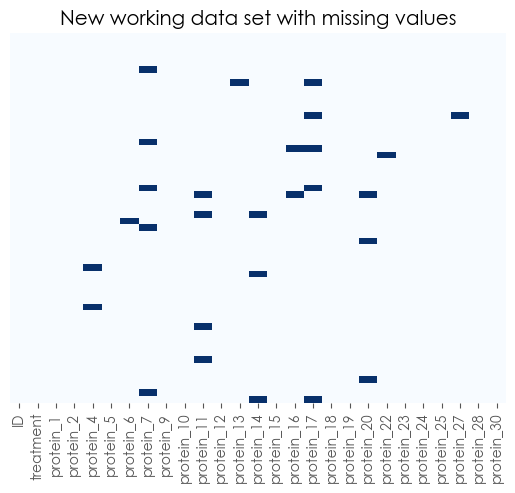

In [13]:
sns.heatmap(df_tmp.isna(), yticklabels=False, cmap = 'Blues', cbar=None)
plt.title('New working data set with missing values');

In [14]:
max_na = df_tmp.isna().sum().sort_values(ascending = False).sum() /len(df_tmp)
print(f'Unfortunately, if removing all the rows, there will only be {round(max_na * 100, 2)}% data left')

Unfortunately, if removing all the rows, there will only be 50.0% data left


In [15]:
df_tmp.describe()

,treatment,protein_1,protein_2,protein_4,protein_5,protein_6,protein_7,protein_9,protein_10,protein_11,...,protein_18,protein_19,protein_20,protein_22,protein_23,protein_24,protein_25,protein_27,protein_28,protein_30
count,56.000000,56.000000,56.000000,54.000000,56.000000,55.000000,51.000000,56.000000,56.000000,52.000000,...,56.000000,56.000000,53.000000,55.000000,56.000000,56.000000,56.000000,55.000000,56.000000,56.000000
mean,14.482143,498.154821,890.978393,211.677222,126.266786,12.139091,23.970392,11.337679,63.545357,20.999423,...,197.684286,177.973393,1.470755,157.851273,26.704286,45.287857,101.483214,242.658182,125.306607,0.813393
std,8.170882,186.790238,1589.506544,1151.981252,903.475385,31.633555,163.004289,25.105040,166.487462,52.568435,...,405.787454,190.616424,2.033265,708.897410,132.662495,59.132523,38.794937,603.519619,751.885176,0.375486
min,3.000000,209.990000,95.050000,0.800000,1.280000,1.280000,0.020000,1.550000,1.360000,0.810000,...,73.330000,9.050000,0.030000,1.660000,1.930000,15.500000,27.890000,8.050000,0.290000,0.250000
25%,3.000000,398.800000,173.345000,4.720000,3.880000,4.140000,0.250000,4.250000,4.625000,2.680000,...,92.485000,67.202500,0.500000,38.770000,6.030000,24.557500,77.740000,103.260000,11.390000,0.520000
50%,18.000000,468.865000,339.130000,10.605000,5.270000,5.630000,0.650000,7.655000,8.435000,6.400000,...,128.185000,98.095000,0.820000,58.990000,7.175000,31.700000,95.445000,160.000000,16.000000,0.755000
75%,22.000000,551.912500,588.320000,105.350000,6.800000,8.020000,1.560000,9.442500,38.452500,15.557500,...,168.015000,215.247500,1.290000,78.880000,10.220000,42.770000,125.302500,213.015000,33.520000,1.002500
max,24.000000,1332.960000,8734.130000,8508.950000,6766.500000,231.440000,1165.160000,190.930000,1059.470000,347.200000,...,3099.330000,883.610000,12.110000,5314.320000,1000.360000,451.680000,191.050000,4594.150000,5647.590000,2.170000


Imputing Data using `SimpleImputer()` and filling in data with the `mean`

In [16]:
imp_mean = SimpleImputer(strategy='mean')
df_imp_ = imp_mean.fit_transform(df_tmp[pt.get_num_var(df_tmp)])
df_imp = pd.DataFrame(df_imp_, columns=pt.get_num_var(df_tmp))

In [17]:
df_imp['ID'] = df_tmp['ID']
df_imp['treatment'] = df_tmp['treatment']

In [18]:
col_list = ['ID', 'treatment'] + pt.get_num_var(df_tmp)
col_list

['ID',
 'treatment',
 'protein_1',
 'protein_2',
 'protein_4',
 'protein_5',
 'protein_6',
 'protein_7',
 'protein_9',
 'protein_10',
 'protein_11',
 'protein_12',
 'protein_13',
 'protein_14',
 'protein_15',
 'protein_16',
 'protein_17',
 'protein_18',
 'protein_19',
 'protein_20',
 'protein_22',
 'protein_23',
 'protein_24',
 'protein_25',
 'protein_27',
 'protein_28',
 'protein_30']

In [19]:
df_imp = df_imp[col_list]

Checking the working file's missing values percentage

In [20]:
df_imp.isna().sum().sort_values(ascending = False) / len(df_imp)

ID            0.0
protein_15    0.0
protein_28    0.0
protein_27    0.0
protein_25    0.0
protein_24    0.0
protein_23    0.0
protein_22    0.0
protein_20    0.0
protein_19    0.0
protein_18    0.0
protein_17    0.0
protein_16    0.0
protein_14    0.0
treatment     0.0
protein_13    0.0
protein_12    0.0
protein_11    0.0
protein_10    0.0
protein_9     0.0
protein_7     0.0
protein_6     0.0
protein_5     0.0
protein_4     0.0
protein_2     0.0
protein_1     0.0
protein_30    0.0
dtype: float64

I will also designate the mice aged 3~11 months as `young` and mice aged 18 and over as `old`

In [21]:
df_imp.rename(mapper = {'treatment':'target'}, axis = 1, inplace=True)

In [22]:
df_imp.target = df_imp.target.map({3: 'young',
                                    11: 'young',
                                     18: 'old',
                                    22: 'old',
                                    24: 'old'})

In [23]:
df_imp.groupby('target').describe()

protein_1                                                           \
           count       mean         std     min      25%     50%      75%   
target                                                                      
old         31.0  549.82129  217.908742  302.08  440.915  510.53  573.155   
young       25.0  434.08840  113.484805  209.99  350.550  429.00  530.030   

                protein_2               ... protein_28          protein_30  \
            max     count         mean  ...        75%      max      count   
target                                  ...                                  
old     1332.96      31.0   477.409032  ...      32.76  5647.59       31.0   
young    650.24      25.0  1403.804400  ...      33.52   198.41       25.0   

                                                          
            mean       std   min   25%   50%   75%   max  
target                                                    
old     0.748387  0.352497  0.25  0.48  0.64  0.91  1.51  
young   0.894000  0.394409  0.37  0.66  0.85  1.03  2.17  

[2 rows x 200 columns]

# 2. Exploring the Data <a name='eda'></a>
    

F Regression analysis of the numerical values column (`df_num_var`) 
From the scikit-learn website: <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html'>link</a>
> 'Univariate linear regression tests returning F-statistic and p-values.'

In [24]:
# getting a list of numerical values
df_num_var = pt.get_num_var(df_imp)

# for f_regression we need to encode our target values
df_f_reg = df_imp.copy()
df_f_reg.target = df_f_reg.target.map({'young':0,
                                       'old' : 1})

pt.get_f_regression(df_f_reg, df_num_var, treatment_col_name='target')

,F statistics,P values
protein_1,5.773879,0.019732
protein_2,5.046792,0.028783
protein_4,0.804669,0.373683
protein_5,0.797472,0.375813
protein_6,1.741834,0.192475
protein_7,0.725848,0.397995
protein_9,0.333844,0.565806
protein_10,0.781389,0.380635
protein_11,3.384003,0.071332
protein_12,4.521816,0.038052


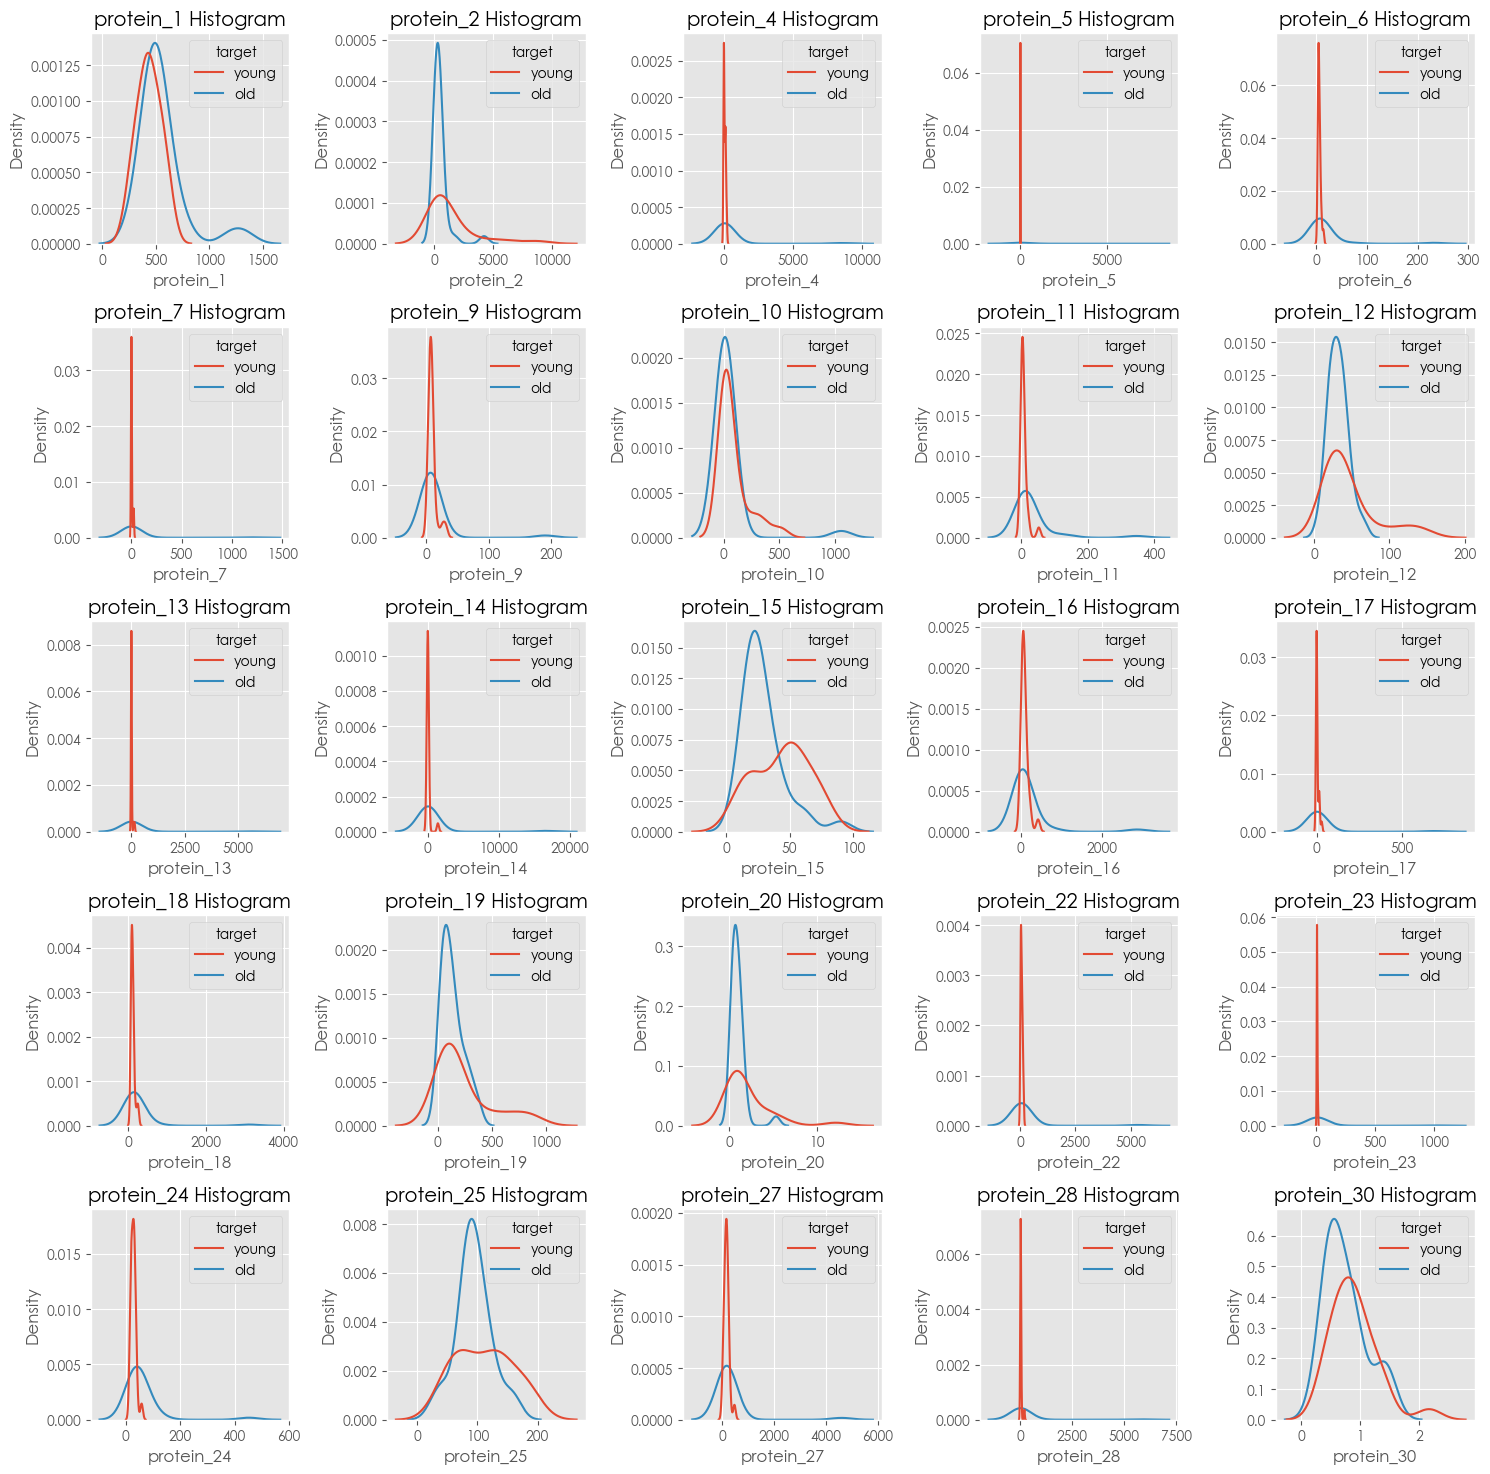

In [25]:
hist_df = pt.hist_all(df_imp, df_num_var, 5, 5, treatment = True, treatment_col_name='target')

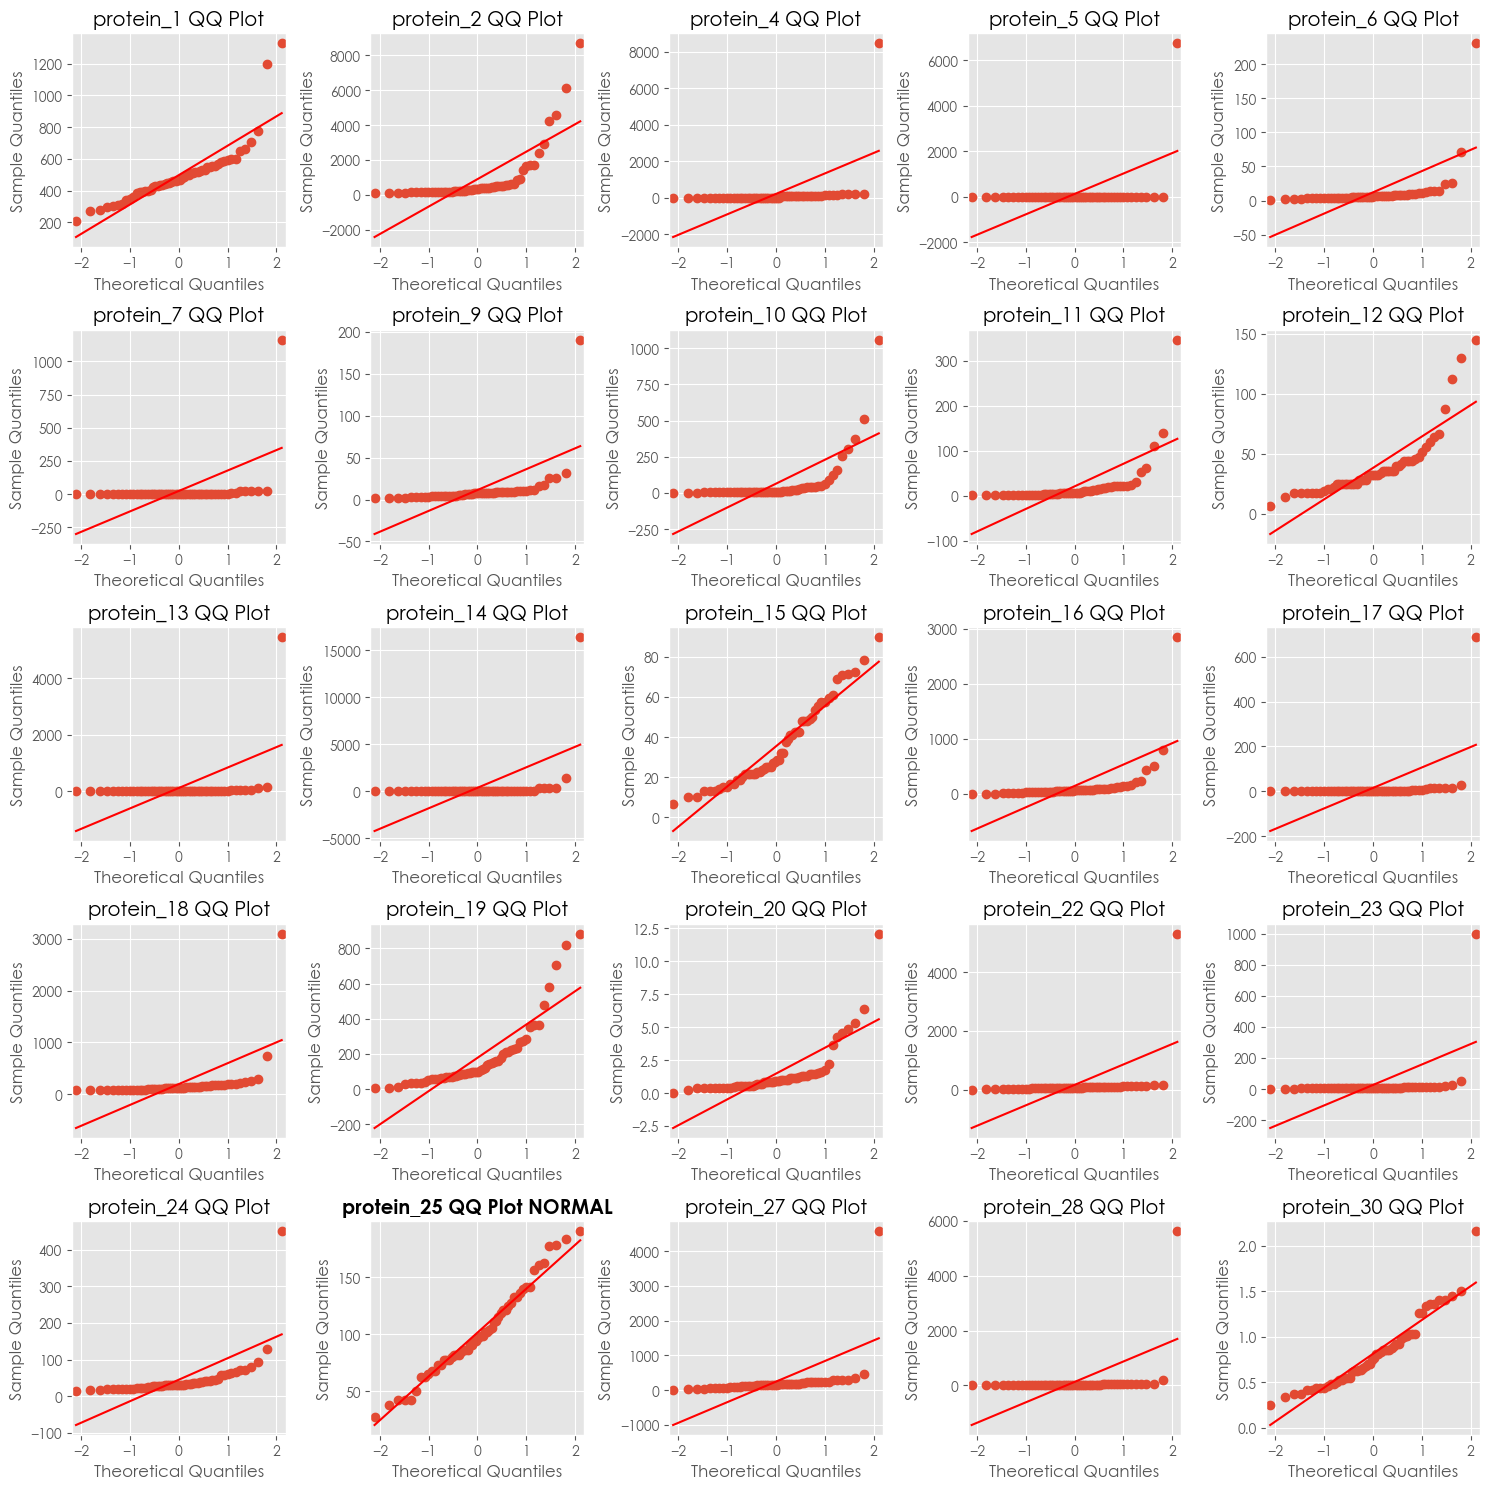

In [26]:
norm_df = pt.normal_all(df_imp, 5, 5, df_num_var, treatment_col_name='target')

In [27]:
pt.normal_table(df_imp, treatment_col_name='target')

,0
protein_1,0.000000
protein_2,0.000000
protein_4,0.000000
protein_5,0.000000
protein_6,0.000000
protein_7,0.000000
protein_9,0.000000
protein_10,0.000000
protein_11,0.000000
protein_12,0.000000


In [28]:
df_imp.drop(index=37, inplace = True, axis = 0) # removed this outlier

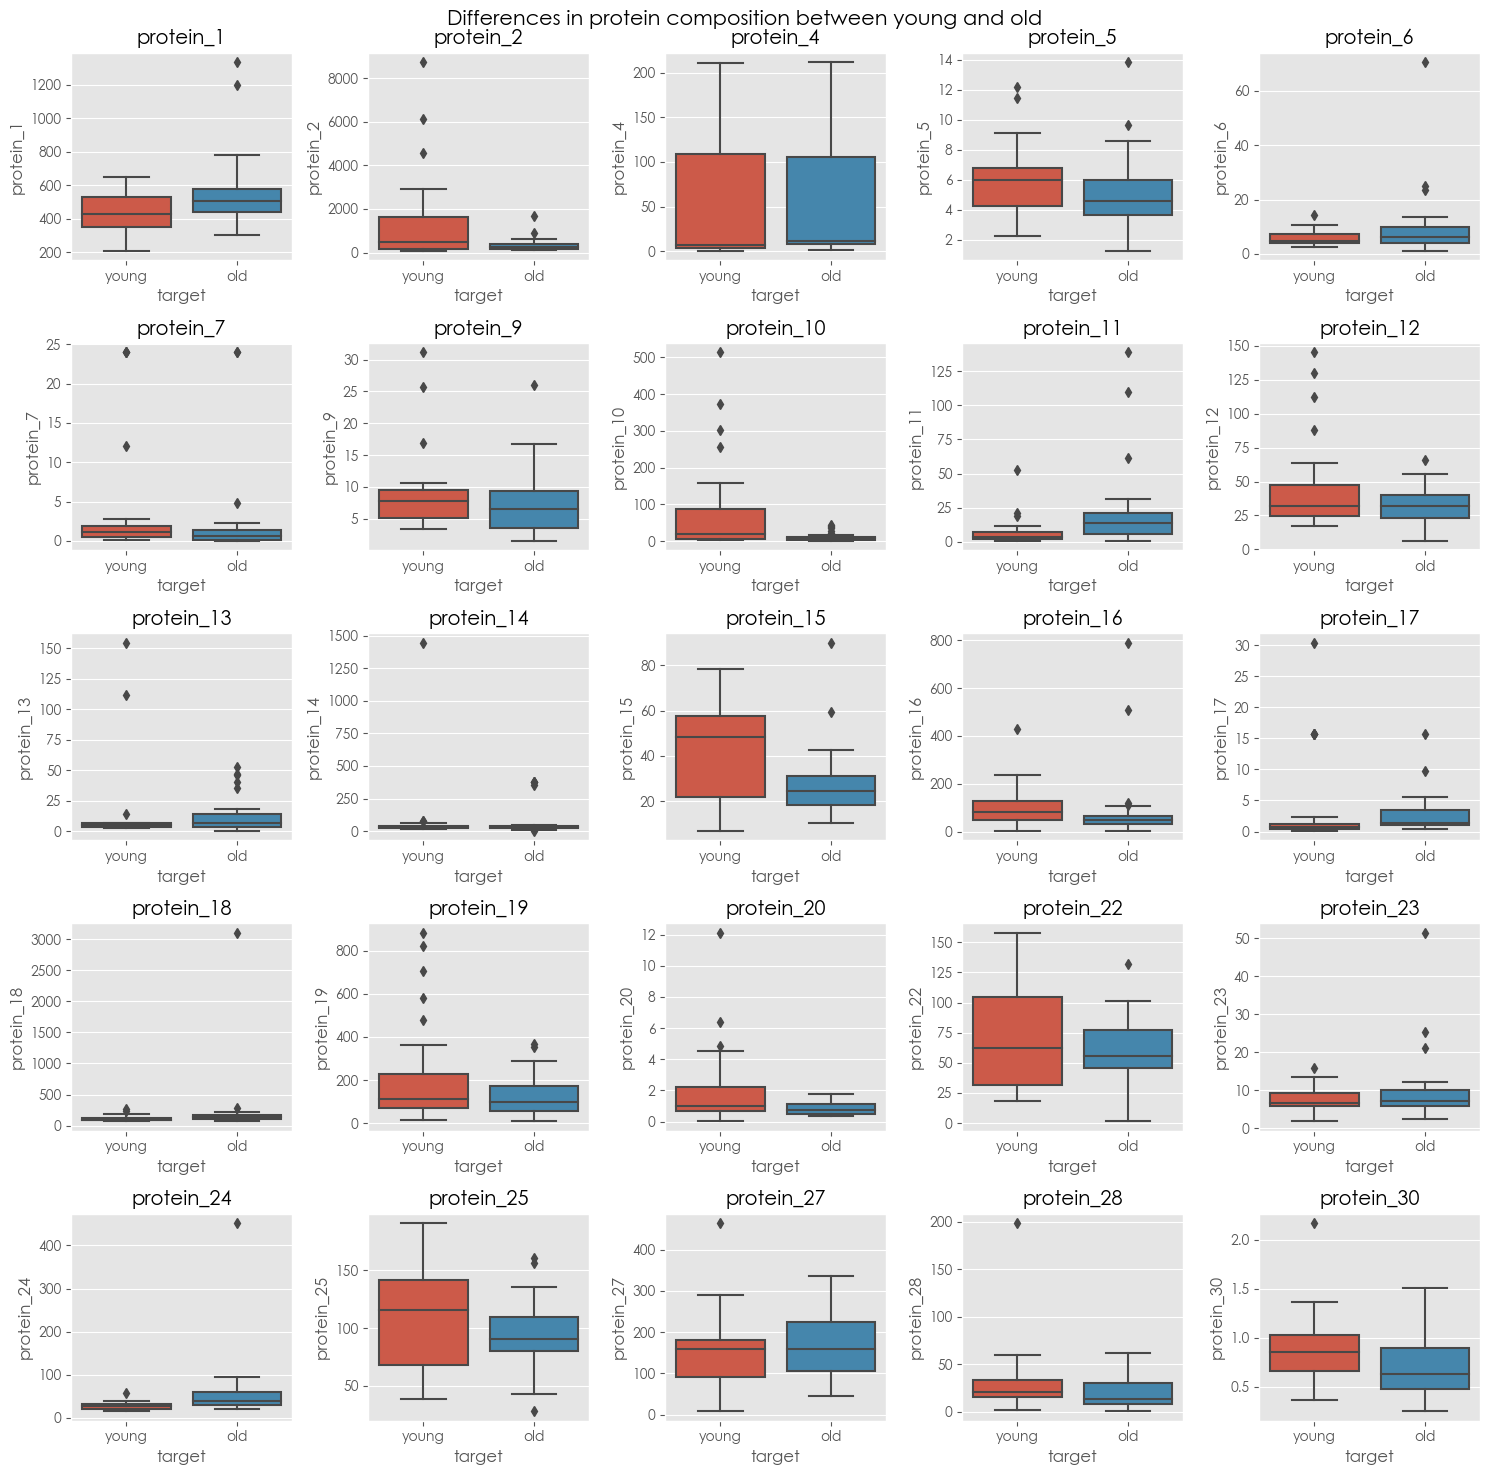

In [29]:
pt.test_all(df_imp, df_num_var, 5, 5, treatment_col_name='target', title = 'Differences in protein composition between young and old')

# 3. Cluster Analysis <a name='cluster'></a>
## 3.1 Cluster Analysis

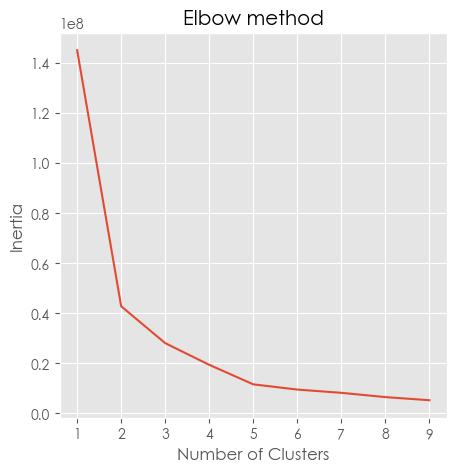

In [30]:
pt.get_elbow(df_imp[df_num_var])

In [31]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state =42)

In [32]:
df_kmeans = kmeans.fit(df_imp[df_num_var])

In [33]:
silhouette_score(df_imp[df_num_var], df_kmeans.labels_)

0.8288819423032511

In [34]:
df_clust = df_imp.copy()
df_clust['clusters'] = df_kmeans.labels_

In [35]:
df_clust.query('clusters==0')

,ID,target,protein_1,protein_2,protein_4,protein_5,protein_6,protein_7,protein_9,protein_10,...,protein_19,protein_20,protein_22,protein_23,protein_24,protein_25,protein_27,protein_28,protein_30,clusters
0,mouse_1,young,425.83,95.05,0.800000,4.91,6.010000,1.120000,5.55,20.75,...,212.07,0.500000,18.460000,8.84,22.32,62.50,160.000000,21.35,0.70,0
1,mouse_2,young,386.18,250.71,3.200000,6.40,4.880000,0.090000,7.86,6.62,...,227.08,4.540000,91.860000,5.30,34.23,86.50,114.860000,43.04,1.36,0
2,mouse_3,young,530.66,180.41,3.700000,4.22,4.140000,2.780000,6.52,7.16,...,99.11,0.030000,45.540000,3.92,20.67,141.29,170.920000,33.52,0.85,0
3,mouse_4,young,390.91,141.88,3.700000,6.80,9.760000,0.490000,10.67,3.70,...,85.32,0.820000,18.460000,9.75,25.13,67.93,181.680000,15.18,1.26,0
4,mouse_5,young,273.75,508.31,4.720000,2.24,7.200000,1.280000,3.35,8.80,...,73.68,12.110000,62.340000,9.29,18.13,77.74,91.550000,21.35,1.03,0
5,mouse_6,young,298.39,233.24,3.200000,3.88,3.420000,23.970392,7.52,5.14,...,72.17,0.350000,25.230000,6.40,17.16,38.20,137.710000,20.42,0.61,0
6,mouse_7,young,315.89,109.16,2.230000,2.56,14.200000,0.170000,4.69,2.86,...,119.95,4.850000,38.770000,6.03,19.52,127.50,8.050000,13.60,2.17,0
7,mouse_8,young,209.99,1405.57,98.060000,3.88,4.140000,1.750000,16.87,40.77,...,81.03,0.500000,25.230000,4.60,15.50,103.67,181.680000,24.16,1.03,0
8,mouse_9,young,602.24,287.64,142.830000,6.40,4.880000,1.040000,10.04,3.03,...,67.59,0.900000,52.280000,4.60,22.52,42.47,181.680000,15.18,0.52,0
9,mouse_10,young,450.03,1705.25,7.020000,6.01,7.200000,0.490000,4.69,86.28,...,208.59,0.660000,72.310000,1.93,23.74,115.37,43.980000,11.39,0.98,0


In [36]:
df_clust.query('clusters==1')

,ID,target,protein_1,protein_2,protein_4,protein_5,protein_6,protein_7,protein_9,protein_10,...,protein_19,protein_20,protein_22,protein_23,protein_24,protein_25,protein_27,protein_28,protein_30,clusters
10,mouse_11,young,553.75,4557.31,153.70,11.45,4.88,1.60,8.25,256.40,...,706.44,0.97,72.31,13.42,20.67,133.18,67.88,11.39,0.74,1
15,mouse_16,young,450.39,8734.13,210.62,3.21,5.63,0.57,3.66,372.93,...,476.85,6.40,52.28,7.57,58.27,139.97,91.55,44.68,1.01,1
17,mouse_18,young,599.38,6133.78,195.67,7.66,4.51,0.17,9.41,513.13,...,820.95,1.52,134.76,4.95,27.67,178.77,103.26,38.92,0.66,1


The highest silhouette score yieled two clusters with a KMeans testing, which failed to identify unique groupings that matched the `treatment` column aka 

## 3.2 Principal Component Analysis <a name='pca'></a>

In [37]:
# getting the X dataframe
X = df_clust[df_num_var]

# scaling the features and fitting the new X
X_scaled = StandardScaler().fit_transform(X)

# instantiating the PCA model
pca = PCA(n_components=2)

# fitting the model using the scaled dataset
principalComponents = pca.fit_transform(X_scaled)
principalDF = pd.DataFrame(principalComponents, columns=['pca1', 'pca2'])

principalDF['clusters'] = df_clust['clusters']
principalDF['target'] = df_clust['target']

principalDF

,pca1,pca2,clusters,target
0,-1.336301,-0.504878,0.0,young
1,-0.040224,-0.244951,0.0,young
2,-1.022531,0.330534,0.0,young
3,-1.934669,-0.672277,0.0,young
4,-0.568559,-0.972041,0.0,young
5,-2.273766,-0.310881,0.0,young
6,-1.089398,-0.945764,0.0,young
7,-0.599362,2.735928,0.0,young
8,-1.407829,-0.682765,0.0,young
9,-0.022544,-0.877470,0.0,young


### Visualizing the Results of the PCA analysis

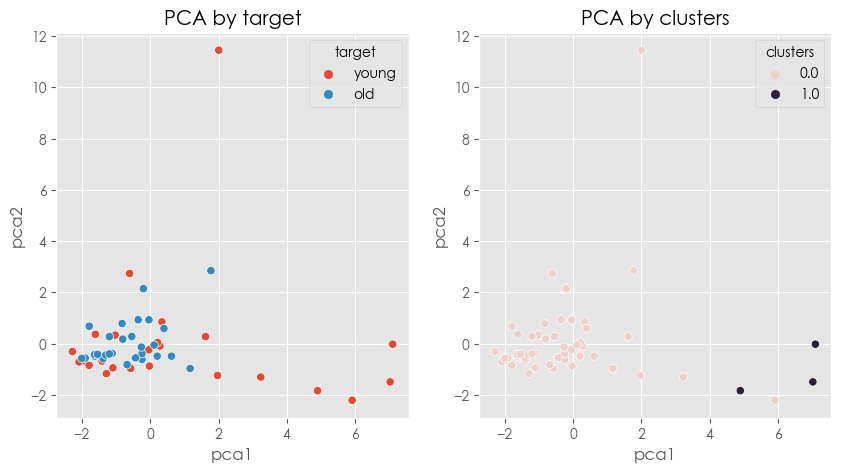

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.scatterplot(ax=ax1, data=principalDF, x = 'pca1', y='pca2', hue='target')
ax1.set(title='PCA by target')
sns.scatterplot(ax=ax2, data=principalDF, x=  'pca1', y='pca2', hue = 'clusters', hue_order=[1,0])
ax2.set(title = 'PCA by clusters');

# 4. Modeling: Predicting Age <a name='predict'>
   

## 4.1 Classification of Young vs Old Samples

In [125]:
# creating a new dataset for classification
df_clf = df_imp.copy()
df_clf.target = df_clf.target.map({'young':0,
                                  'old':1})

In [126]:
from sklearn.model_selection import train_test_split

X = df_clf.drop(['target', 'ID'], axis = 1)
y = df_clf['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44, 25), (11, 25), (44,), (11,))

In [127]:
# importing the libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xg

# classifier metrics and evaluators
from sklearn.metrics import classification_report, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [128]:
np.random.seed(42)
# creating a dict of models to train
model_dict = {'LogRegression': LogisticRegression(),
             'RandomForest': RandomForestClassifier(),
             'SVC': SVC(),
             'XGBoostClassifier': xg.XGBClassifier()}

score_dict = {}
recall_score_dict = {}
precision_score_dict = {}
f1_score_dict = {}


for model_name, model in model_dict.items():
    # creating a pipeline for scaling numerical columns
    num_pipe = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    column_transformer = ColumnTransformer(transformers=[
        ('num', num_pipe, df_num_var)
    ])
    model_pipeline = Pipeline(steps=[
        ('model', model)
    ])
    
    # fitting the model
    clf_model = model_pipeline.fit(X_train, y_train)
    y_preds = clf_model.predict(X_test)
    
    score_dict[model_name] = clf_model.score(X_test, y_test)
    recall_score_dict[model_name] = recall_score(y_test, y_preds)
    precision_score_dict[model_name] = precision_score(y_test, y_preds)
    f1_score_dict[model_name] = f1_score(y_test, y_preds)

In [129]:
# creating a new dataframe for compiling results of inital scores
scores_df = pd.DataFrame(score_dict.values(), score_dict.keys(), columns=['Score'])
recall_df = pd.DataFrame(recall_score_dict.values(), recall_score_dict.keys(), columns=['Recall Score'])
precision_df = pd.DataFrame(precision_score_dict.values(), precision_score_dict.keys(), columns=['Precision Score'])
f1_df = pd.DataFrame(f1_score_dict.values(), f1_score_dict.keys(), columns=['F1 Score'])

scores = scores_df.join(recall_df).join(precision_df).join(f1_df)
scores

,Score,Recall Score,Precision Score,F1 Score
LogRegression,0.727273,0.666667,0.800000,0.727273
RandomForest,0.909091,1.000000,0.857143,0.923077
SVC,0.636364,0.833333,0.625000,0.714286
XGBoostClassifier,0.909091,1.000000,0.857143,0.923077


Looking at the scores above it seems like RandomForest pereformed the best, so we will be looking at this for hyperparamter tuning

In [130]:
np.random.seed(42)

# creating a pipeline for scaling numerical columns
num_pipe = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
column_transformer = ColumnTransformer(transformers=[
        ('num', num_pipe, df_num_var)
    ])
model_pipeline = Pipeline(steps=[
        ('model', RandomForestClassifier())
    ])
rf_model = model_pipeline.fit(X_train, y_train)

In [131]:
rf_model.score(X_test, y_test)

0.9090909090909091

In [133]:
pd.DataFrame(rf_model.get_params().values(), rf_model.get_params().keys())

0
memory                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [135]:
# Using RandomizedSearchCV for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}
rs_rf_clf_model = RandomizedSearchCV(model_pipeline,
                             param_distributions=random_grid,
                             n_iter = 40, 
                             cv = 5, verbose = True, 
                             random_state=42, n_jobs = -1)

In [136]:
rs_rf_clf_model.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier())]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, 110, None],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 218, 236,
                                                                254, 272, 290,
                                                                309, 327, 345,
                                                                363, 381, 400,
                                                                418, 436, 454,
                                                                472, 490, 509,
                                                                527, 545, 563,
                                                                581, 600, 618,
                                                                636, 654, 672,
                                                                690, 709, 727, ...]},
                   random_state=42, verbose=True)

In [137]:
rs_rf_clf_model.score(X_test, y_test)

0.9090909090909091

In [138]:
rs_rf_clf_model.best_params_

{'model__n_estimators': 527,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'sqrt',
 'model__max_depth': 110,
 'model__bootstrap': True}

Seeing the very minimal increase in score through the initial hyperparameter tuning, I will acquire more data and perform feature selection for improving the score

Evaluating the classifier with a confusion matrix and ROC Curve

In [139]:
# creating functions for confusion matrix and ROC Curve

def plot_confusion_matrix(model, X_test, y_test):
    '''
    plotting the confusion matrix
    '''
    cm = confusion_matrix(y_test, model.predict(X_test))
    ConfusionMatrixDisplay(cm).plot(cmap='Blues');


def plot_roc_curve(model, X_test, y_test):
    '''
    plotting the roc curve
    '''
    # getting the positive probabilities 
    preds_proba = model.predict_proba(X_test)[: ,1]
        
    # getting the fpr, tpr, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds_proba)
        
    # plotting the ROC Curve
    fig, ax = plt.subplots(figsize = (3,3))
    ax.plot(fpr, tpr, label = 'ROC')
    ax.plot([0,1], label = 'True')
    ax.set(title = 'Plot of the ROC Curve',
          ylabel = 'TPR',
             xlabel = 'FPR')
    ax.legend();

def model_report(model, X_test, y_test):
    '''
    output of the classification report
    '''
    
    return classification_report(y_test, model.predict(X_test))

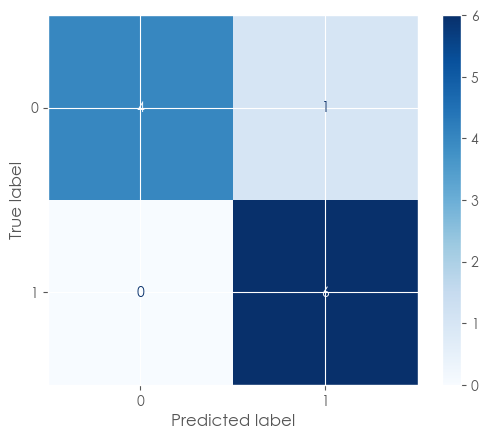

In [140]:
plot_confusion_matrix(rs_rf_clf_model, X_test, y_test)

In [141]:
print(model_report(rs_rf_clf_model, X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.86      1.00      0.92         6

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      0.91      0.91        11



### Saving the classifier model

In [54]:
from joblib import dump
dump(rs_rf_clf_model, "classifer_aging_model.joblib")

['classifer_aging_model.joblib']

## 4.2 Regression <a name='regression'></a>

Because the classification dataset looks different than our regression dataset, we will perform a quick EDA and clean up for prior to the modeling
### 4.2.1 EDA

In [55]:
df_reg = pd.read_csv('t_cell_panel.csv')
df_reg.head()

,ID,treatment,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
0,mouse_1,2.95,95.05,2.25,0.80,4.91,6.01,0.35,5.55,20.75,11.82,6.74,20.63,50.04,NaN,0.79,212.07,18.46,160.00,160.00
1,mouse_2,2.95,250.71,3.22,3.20,6.40,4.88,2.17,7.86,6.62,18.81,6.06,81.33,70.72,93.00,1.17,227.08,91.86,114.86,114.86
2,mouse_3,2.95,180.41,6.15,3.70,4.22,4.14,0.70,6.52,7.16,1.75,14.61,77.52,21.77,401.98,2.27,99.11,45.54,170.92,170.92
3,mouse_4,2.95,141.88,2.09,3.70,6.80,9.76,0.35,10.67,3.70,2.22,6.74,28.21,57.46,283.06,0.28,85.32,18.46,181.68,181.68
4,mouse_5,2.95,508.31,4.36,4.72,2.24,7.20,0.16,3.35,8.80,2.68,5.07,24.42,48.20,65.77,0.57,73.68,62.34,91.55,91.55


In [56]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          155 non-null    object 
 1   treatment   155 non-null    float64
 2   protein_1   142 non-null    float64
 3   protein_2   101 non-null    float64
 4   protein_3   131 non-null    float64
 5   protein_4   137 non-null    float64
 6   protein_5   147 non-null    float64
 7   protein_6   128 non-null    float64
 8   protein_7   154 non-null    float64
 9   protein_8   152 non-null    float64
 10  protein_9   115 non-null    float64
 11  protein_10  148 non-null    float64
 12  protein_11  142 non-null    float64
 13  protein_12  154 non-null    float64
 14  protein_13  140 non-null    float64
 15  protein_14  146 non-null    float64
 16  protein_15  154 non-null    float64
 17  protein_16  140 non-null    float64
 18  protein_17  139 non-null    float64
 19  protein_18  150 non-null    f

In [57]:
df_reg.isna().sum().sort_values(ascending=False) / len(df_reg)

protein_2     0.348387
protein_9     0.258065
protein_6     0.174194
protein_3     0.154839
protein_4     0.116129
protein_17    0.103226
protein_13    0.096774
protein_16    0.096774
protein_1     0.083871
protein_11    0.083871
protein_14    0.058065
protein_5     0.051613
protein_10    0.045161
protein_18    0.032258
protein_8     0.019355
protein_12    0.006452
protein_15    0.006452
protein_7     0.006452
treatment     0.000000
ID            0.000000
dtype: float64

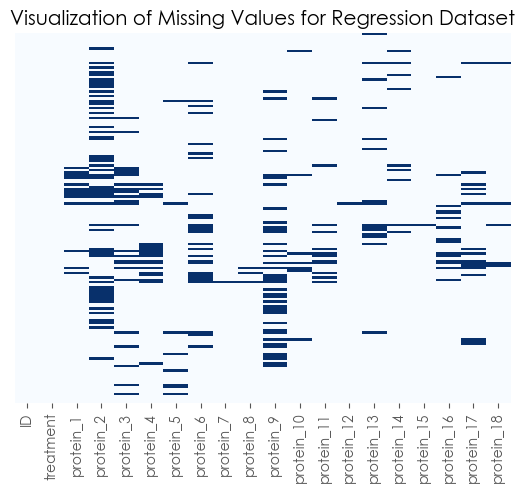

In [58]:
sns.heatmap(df_reg.isna(), yticklabels=False, cmap='Blues', cbar=None)
plt.title('Visualization of Missing Values for Regression Dataset');

Due to the excessive missing values in the IFNy I will remove this column (along with IL-7, IL-4, IL-1a, IL-1b, MIP-2) for now. Will need to include more data from other projects later!

In [59]:
# removing the whitespace from the column names
df_reg.columns = df_reg.columns.str.strip()

In [62]:
# dropping the columns:
df_reg.drop(columns=['protein_2','protein_9', 'protein_6', 'protein_3', 'protein_4'], inplace = True, axis = 1)

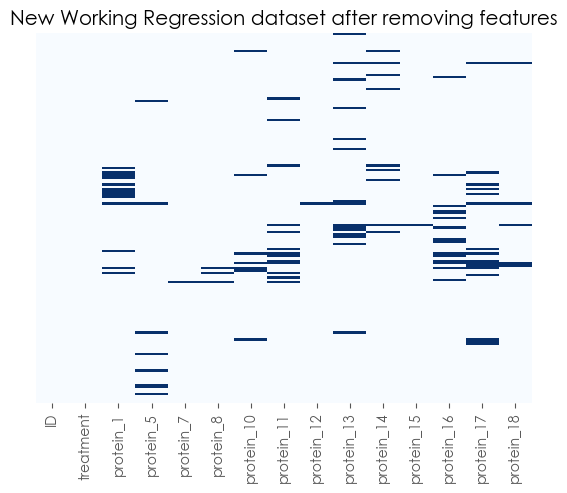

In [63]:
sns.heatmap(df_reg.isna(), yticklabels=False, cmap = 'Blues', cbar = None)
plt.title('New Working Regression dataset after removing features');

In [64]:
max_na = df_reg.isna().sum().sort_values(ascending = False).sum() /len(df_reg)
print(f'Unfortunately, if removing all the rows, there will only be {round(max_na * 100, 2)}% data left')

Unfortunately, if removing all the rows, there will only be 69.03% data left


In [65]:
df_reg.describe()

,treatment,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
count,155.000000,142.000000,147.000000,154.000000,152.000000,148.000000,142.000000,154.000000,140.000000,146.000000,154.000000,140.000000,139.000000,150.000000
mean,12.580423,377.865070,24.878231,25.033377,2018.522763,210.804865,163.055704,155.625325,292.432643,500.521438,1658.561558,283.846500,1462.116043,149.188867
std,8.049454,1078.990642,75.465970,79.485082,7082.104313,921.586491,1382.911204,308.741284,794.494150,1401.366692,5686.493682,1284.167092,5214.188420,477.078804
min,2.950000,0.390000,1.260000,0.280000,0.030000,0.210000,0.420000,0.220000,0.030000,0.100000,1.620000,1.660000,7.020000,0.650000
25%,5.470000,7.195000,4.205000,4.145000,4.282500,3.865000,8.415000,17.495000,2.275000,1.182500,40.012500,18.460000,43.980000,6.090000
50%,8.290000,36.235000,6.160000,7.850000,9.265000,6.290000,21.580000,38.690000,22.865000,34.455000,107.920000,38.425000,74.950000,30.950000
75%,18.900000,283.125000,12.610000,12.590000,42.725000,12.862500,37.207500,116.035000,190.885000,291.327500,251.357500,72.310000,182.920000,146.125000
max,24.820000,8734.130000,684.380000,742.360000,30349.540000,7851.310000,16453.350000,2051.750000,5911.440000,9639.800000,29011.820000,8969.020000,37108.460000,4594.150000


Imputing Data using `SimpleImputer()` and filling in data with the `mean`

In [66]:
reg_imputer_mean = SimpleImputer(strategy='mean')
df_reg_imp = reg_imputer_mean.fit_transform(df_reg[df_reg.drop(['ID', 'treatment'], axis = 1).columns])
reg_imp = pd.DataFrame(df_reg_imp, columns=df_reg.drop(['ID', 'treatment'], axis = 1).columns)


reg_imp['ID'] = df_reg['ID']
reg_imp['treatment'] = df_reg['treatment']

col_list_ = ['ID'] + pt.get_num_var(df_reg)


reg_imp = reg_imp[col_list_]

In [67]:
reg_imp.isna().sum()

ID            0
treatment     0
protein_1     0
protein_5     0
protein_7     0
protein_8     0
protein_10    0
protein_11    0
protein_12    0
protein_13    0
protein_14    0
protein_15    0
protein_16    0
protein_17    0
protein_18    0
dtype: int64

In [68]:
reg_num_var = reg_imp.drop(['treatment', 'ID'], axis = 1).columns
reg_num_var # the numerical features only (excluding the ID and treatment column)

Index(['protein_1', 'protein_5', 'protein_7', 'protein_8', 'protein_10',
       'protein_11', 'protein_12', 'protein_13', 'protein_14', 'protein_15',
       'protein_16', 'protein_17', 'protein_18'],
      dtype='object')

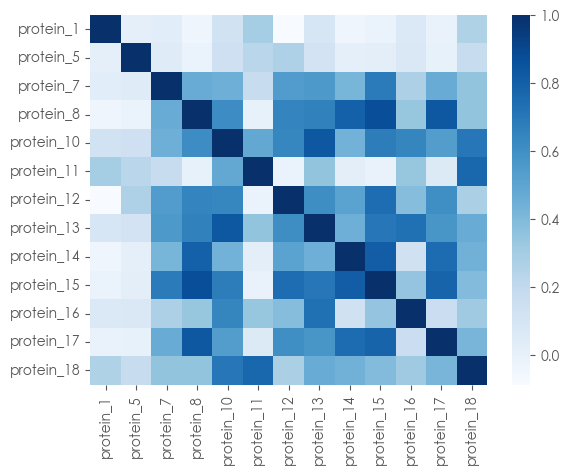

In [69]:
# creating a correlation matrix
reg_corr = reg_imp[reg_num_var].corr()
sns.heatmap(reg_corr, cmap='Blues', annot = False);

In [70]:
reg_corr.style.background_gradient(cmap='Blues')

,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
protein_1,1.000000,0.011015,0.034618,-0.033153,0.121911,0.299277,-0.086719,0.090736,-0.038517,-0.014866,0.066418,-0.008859,0.257607
protein_5,0.011015,1.000000,0.047626,-0.015931,0.140729,0.230473,0.269514,0.114117,0.015945,0.019740,0.072859,0.000334,0.173803
protein_7,0.034618,0.047626,1.000000,0.465943,0.451486,0.177315,0.544882,0.554896,0.424960,0.688348,0.270799,0.467717,0.350671
protein_8,-0.033153,-0.015931,0.465943,1.000000,0.612097,0.000955,0.649290,0.664199,0.795821,0.872947,0.338315,0.830483,0.352807
protein_10,0.121911,0.140729,0.451486,0.612097,1.000000,0.483185,0.640224,0.830308,0.439439,0.678351,0.644995,0.537715,0.698679
protein_11,0.299277,0.230473,0.177315,0.000955,0.483185,1.000000,-0.013991,0.351631,0.023304,-0.007159,0.339039,0.058573,0.768837
protein_12,-0.086719,0.269514,0.544882,0.649290,0.640224,-0.013991,1.000000,0.607936,0.513859,0.743182,0.380482,0.604076,0.274400
protein_13,0.090736,0.114117,0.554896,0.664199,0.830308,0.351631,0.607936,1.000000,0.450833,0.706785,0.732271,0.571721,0.468094
protein_14,-0.038517,0.015945,0.424960,0.795821,0.439439,0.023304,0.513859,0.450833,1.000000,0.811285,0.133325,0.749017,0.439791
protein_15,-0.014866,0.019740,0.688348,0.872947,0.678351,-0.007159,0.743182,0.706785,0.811285,1.000000,0.349999,0.780752,0.393298


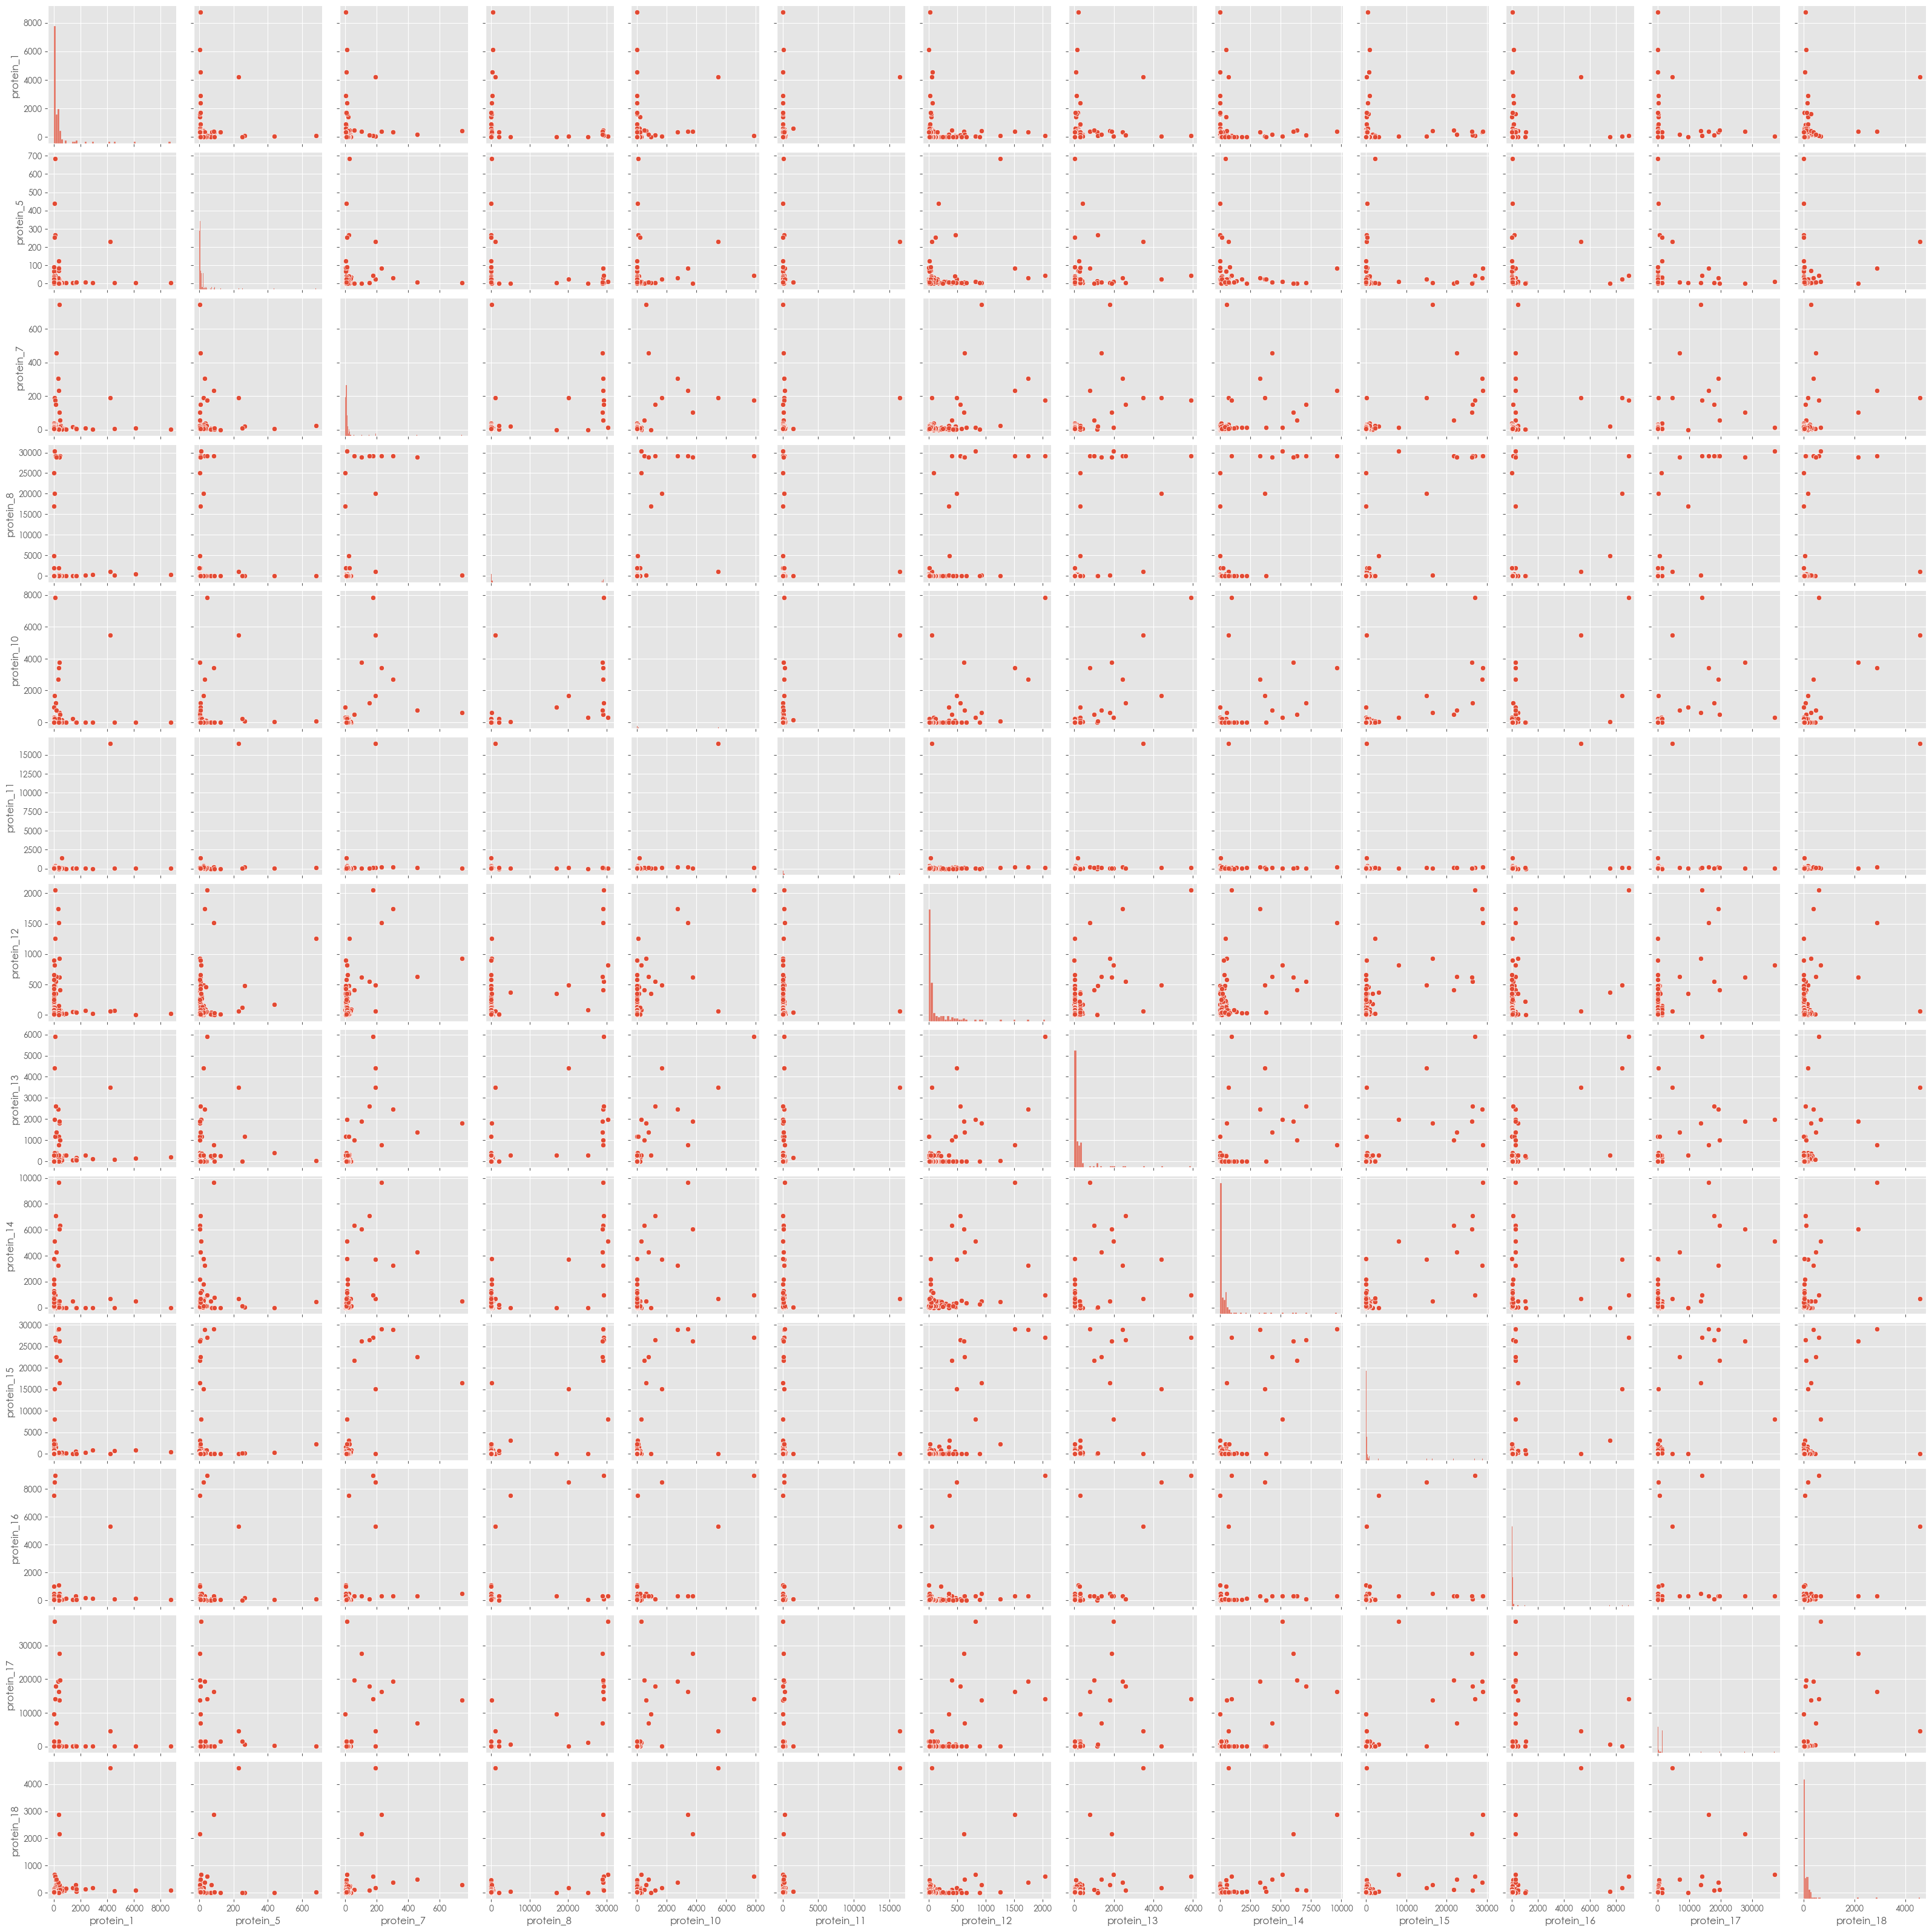

In [71]:
sns.pairplot(reg_imp[reg_num_var])

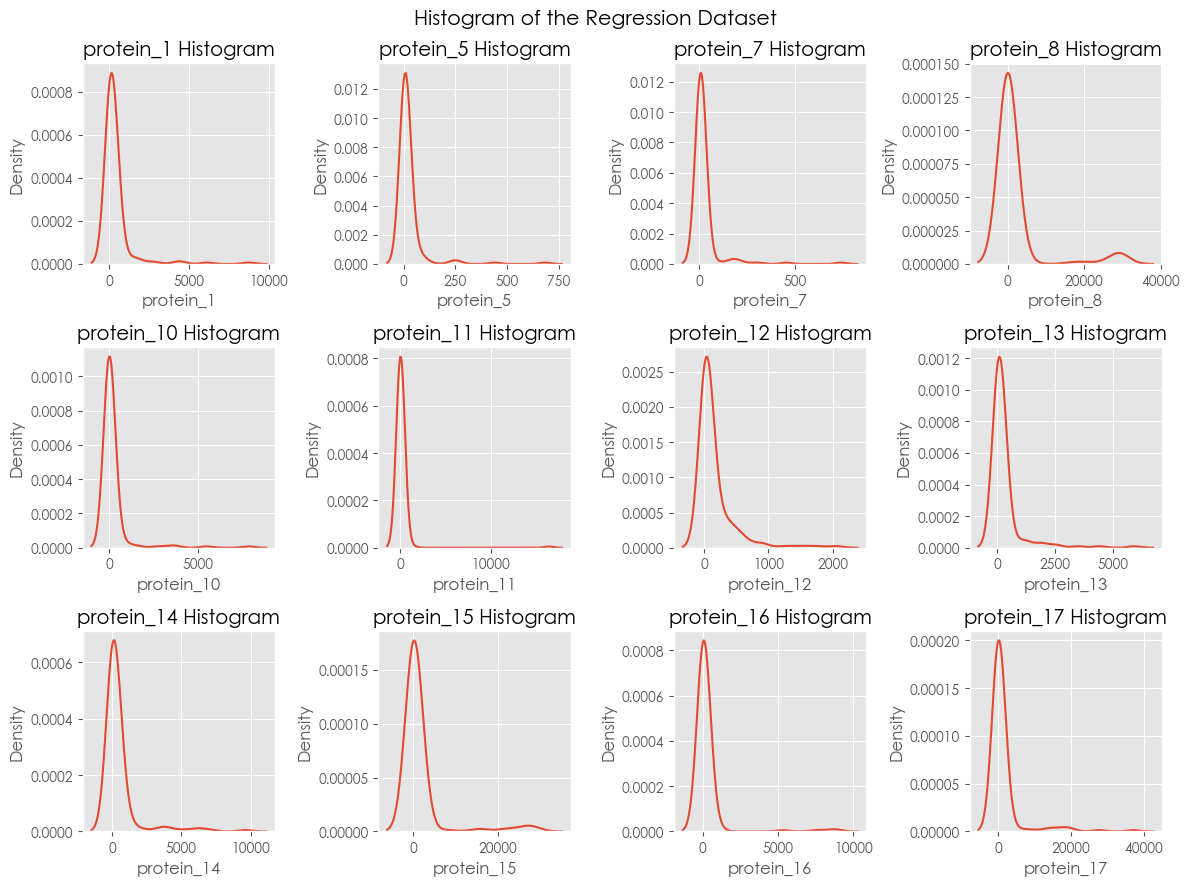

In [72]:
hist_reg = pt.hist_all(reg_imp, reg_num_var, 4, 3, title = 'Histogram of the Regression Dataset', treatment = False)

#### Outlier Detection
We will be using the Tukey's Rule to remove and detect outliers. This is simply calculating the upper boundary as $Q3 + 1.5IQR$ and the lower boundary as $Q1 - 1.5IQR$ , where the $IQR = Q3 - Q1$

In [73]:
# first setting the index of the dataset as ID
reg_imp = reg_imp.set_index('ID')

In [74]:
# creating a function for calculating the IQR:
def getting_IQR(series):
    '''
    Using the input pd.Series to output the IQR, and the upper_lim, lower_lim
    '''
    Q3 = series.quantile(0.75)
    Q1 = series.quantile(0.25)
    
    IQR = Q3 - Q1
    
    #lower boundary
    lower_lim = Q1 - (1.5 * IQR)
    
    # upper boundary
    upper_lim = Q3 + (1.5 * IQR)
    print(f'IQR = {IQR}, lower lim = {lower_lim}, upper_lim = {upper_lim}')
    
    return IQR, upper_lim, lower_lim 

outlier_dict = {}



# returning the index (ID) values of the subjects with higher/lower values than the upper / lower limit
for col_name, content in reg_imp[reg_num_var].items():
    IQR, upper_lim, lower_lim = getting_IQR(content)
    index_upper = list(reg_imp[reg_imp[col_name] > upper_lim].index)
    index_lower = list(reg_imp[reg_imp[col_name] < lower_lim].index)
    outlier_dict[col_name] = {'Upper Outliers': index_upper, 
                              'Lower Outliers' :index_lower}
pd.set_option('display.max_colwidth', None)
pd.DataFrame(outlier_dict)


IQR = 370.1650704225352, lower lim = -547.5476056338027, upper_lim = 933.1126760563379
IQR = 9.294999999999998, lower lim = -9.447499999999998, upper_lim = 27.732499999999995
IQR = 8.530000000000001, lower lim = -8.615000000000002, upper_lim = 25.505000000000003
IQR = 39.43, lower lim = -54.809999999999995, upper_lim = 102.91
IQR = 11.335, lower lim = -13.037500000000001, upper_lim = 32.3025
IQR = 37.925000000000004, lower lim = -47.627500000000005, upper_lim = 104.0725
IQR = 108.085, lower lim = -144.3275, upper_lim = 288.0125
IQR = 254.95, lower lim = -379.81499999999994, upper_lim = 639.9849999999999
IQR = 374.05999999999995, lower lim = -559.8699999999999, upper_lim = 936.3699999999999
IQR = 212.79500000000002, lower lim = -279.1275, upper_lim = 572.0525
IQR = 71.59, lower lim = -87.11500000000001, upper_lim = 199.245
IQR = 195.59, lower lim = -245.725, upper_lim = 536.635
IQR = 143.0188666666667, lower lim = -208.35830000000007, upper_lim = 363.71716666666674


,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
Upper Outliers,"[mouse_8, mouse_10, mouse_11, mouse_12, mouse_16, mouse_17, mouse_18, mouse_19, mouse_26, mouse_38]","[mouse_38, mouse_46, mouse_57, mouse_62, mouse_63, mouse_64, mouse_67, mouse_70, mouse_75, mouse_76, mouse_79, mouse_95, mouse_114, mouse_128, mouse_129, mouse_130, mouse_133, mouse_134, mouse_138, mouse_150]","[mouse_14, mouse_21, mouse_31, mouse_38, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_87, mouse_88, mouse_95, mouse_130, mouse_133]","[mouse_11, mouse_12, mouse_16, mouse_17, mouse_18, mouse_19, mouse_38, mouse_59, mouse_69, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_82, mouse_83, mouse_85, mouse_87, mouse_88, mouse_99, mouse_101, mouse_105, mouse_113, mouse_154]","[mouse_8, mouse_25, mouse_33, mouse_38, mouse_39, mouse_44, mouse_47, mouse_52, mouse_60, mouse_70, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_82, mouse_83, mouse_85, mouse_87, mouse_88, mouse_89, mouse_92, mouse_93, mouse_95, mouse_97, mouse_99, mouse_100, mouse_114, mouse_129]","[mouse_25, mouse_28, mouse_33, mouse_37, mouse_38, mouse_56, mouse_70, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_81, mouse_84, mouse_88, mouse_91, mouse_93, mouse_94, mouse_95, mouse_96, mouse_97, mouse_101, mouse_103, mouse_105, mouse_141, mouse_145, mouse_146, mouse_152, mouse_154]","[mouse_70, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_82, mouse_85, mouse_86, mouse_87, mouse_88, mouse_89, mouse_95, mouse_107, mouse_110, mouse_111, mouse_112, mouse_113, mouse_114, mouse_117, mouse_120, mouse_125]","[mouse_38, mouse_39, mouse_61, mouse_70, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_87, mouse_88]","[mouse_73, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_87, mouse_88, mouse_141, mouse_142, mouse_147, mouse_149, mouse_154]","[mouse_11, mouse_17, mouse_18, mouse_19, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_80, mouse_81, mouse_84, mouse_85, mouse_87, mouse_88, mouse_89, mouse_90, mouse_95, mouse_98, mouse_100, mouse_103, mouse_105, mouse_130, mouse_134]","[mouse_19, mouse_38, mouse_60, mouse_68, mouse_73, mouse_74, mouse_75, mouse_76, mouse_77, mouse_78, mouse_79, mouse_82, mouse_84, mouse_85, mouse_86, mouse_87, mouse_88, mouse_93, mouse_94, mouse_96, mouse_97, mouse_99, mouse_100, mouse_104]","[mouse_13, mouse_38, mouse_59, mouse_64, mouse_66, mouse_68, mouse_70, mouse_72, mouse_73, mouse_74, mouse_75, mouse_76, mouse_78, mouse_79, mouse_80, mouse_82, mouse_83, mouse_85, mouse_87, mouse_88, mouse_89, mouse_91, mouse_93, mouse_96, mouse_97, mouse_98, mouse_99, mouse_102, mouse_129, mouse_130, mouse_131]","[mouse_24, mouse_38, mouse_73, mouse_75, mouse_76, mouse_79, mouse_87, mouse_88]"
Lower Outliers,[],[],[],[],[],[],[],[],[],[],[],[],[]


Looking at this above, it seems like most of the outliers are ABOVE the limit (not lower)

In [75]:
outliers = []
for key, val in outlier_dict.items():
    for num in val['Upper Outliers']:
        outliers.append(num)
    
outliers_unique = set(outliers)
i = 0
for n in outliers_unique:
    i += 1

print(f'There are {i} indexes that are uniquely outliers')

There are 96 indexes that are uniquely outliers


In [76]:
reg_imp_outlier_removed = reg_imp.drop(index = list(outliers_unique), axis = 0)

In [77]:
reg_imp_outlier_removed

,treatment,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
ID,,,,,,,,,,,,,,
mouse_1,2.9500,95.05,6.010000,5.55,20.75,6.74,20.63,50.04,292.432643,0.790000,212.07,18.46,160.00,160.00
mouse_2,2.9500,250.71,4.880000,7.86,6.62,6.06,81.33,70.72,93.000000,1.170000,227.08,91.86,114.86,114.86
mouse_3,2.9500,180.41,4.140000,6.52,7.16,14.61,77.52,21.77,401.980000,2.270000,99.11,45.54,170.92,170.92
mouse_4,2.9500,141.88,9.760000,10.67,3.70,6.74,28.21,57.46,283.060000,0.280000,85.32,18.46,181.68,181.68
mouse_5,2.9500,508.31,7.200000,3.35,8.80,5.07,24.42,48.20,65.770000,0.570000,73.68,62.34,91.55,91.55
mouse_6,2.9500,233.24,3.420000,7.52,5.14,2.84,32.00,53.73,23.270000,0.220000,72.17,25.23,137.71,137.71
mouse_7,3.0200,109.16,14.200000,4.69,2.86,4.10,22.53,42.75,133.850000,0.220000,119.95,38.77,8.05,8.05
mouse_9,3.0200,287.64,4.880000,10.04,3.03,3.47,39.58,57.46,255.320000,0.790000,67.59,52.28,181.68,181.68
mouse_15,3.0200,133.78,3.420000,4.11,2.53,3.47,28.21,78.43,240.960000,0.680000,56.42,38.77,243.25,243.25


In [78]:
len(reg_imp_outlier_removed)

59

In [79]:
# testing if there are any more outliers in this new dataset
outlier_dict_test = {}

# returning the index (ID) values of the subjects with higher/lower values than the upper / lower limit
for col_name, content in reg_imp_outlier_removed[reg_num_var].items():
    IQR, upper_lim, lower_lim = getting_IQR(content)
    index_upper = list(reg_imp_outlier_removed[reg_imp_outlier_removed[col_name] > upper_lim].index)
    index_lower = list(reg_imp_outlier_removed[reg_imp_outlier_removed[col_name] < lower_lim].index)
    outlier_dict[col_name] = {'Upper Outliers': index_upper, 
                              'Lower Outliers' :index_lower}
pd.set_option('display.max_colwidth', None)
pd.DataFrame(outlier_dict_test)

IQR = 233.18000000000004, lower lim = -340.975, upper_lim = 591.7450000000001
IQR = 6.910000000000001, lower lim = -5.870000000000002, upper_lim = 21.770000000000003
IQR = 5.890000000000001, lower lim = -4.32, upper_lim = 19.240000000000002
IQR = 8.15, lower lim = -8.360000000000001, upper_lim = 24.240000000000002
IQR = 5.889999999999999, lower lim = -5.364999999999997, upper_lim = 18.194999999999997
IQR = 22.990000000000002, lower lim = -25.475, upper_lim = 66.485
IQR = 38.30499999999999, lower lim = -37.36749999999999, upper_lim = 115.85249999999999
IQR = 225.35999999999999, lower lim = -336.27, upper_lim = 565.17
IQR = 154.28, lower lim = -230.52, upper_lim = 386.6
IQR = 121.98, lower lim = -146.14499999999998, upper_lim = 341.775
IQR = 42.245000000000005, lower lim = -44.947500000000005, upper_lim = 124.03250000000001
IQR = 113.355, lower lim = -123.3875, upper_lim = 330.0325
IQR = 153.775, lower lim = -224.43750000000003, upper_lim = 390.6625


""


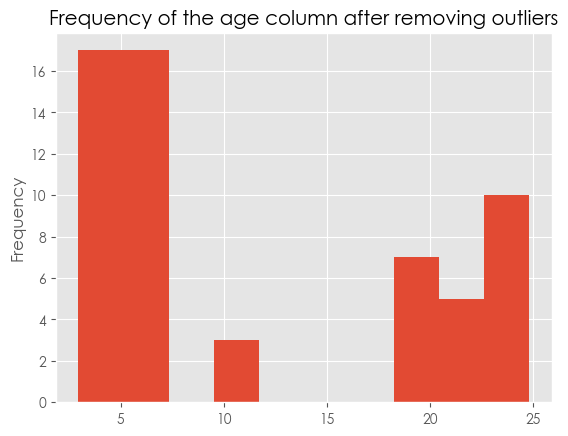

In [80]:
reg_imp_outlier_removed['treatment'].plot(kind='hist')
plt.title('Frequency of the age column after removing outliers');

In [81]:
pt.get_f_regression(reg_imp_outlier_removed, reg_num_var)

,F statistics,P values
protein_1,13.515018,0.000525
protein_5,1.031063,0.314200
protein_7,2.040135,0.158653
protein_8,1.632952,0.206475
protein_10,2.343478,0.131340
protein_11,0.001146,0.973109
protein_12,8.398319,0.005322
protein_13,9.566914,0.003066
protein_14,8.031017,0.006349
protein_15,2.092282,0.153522


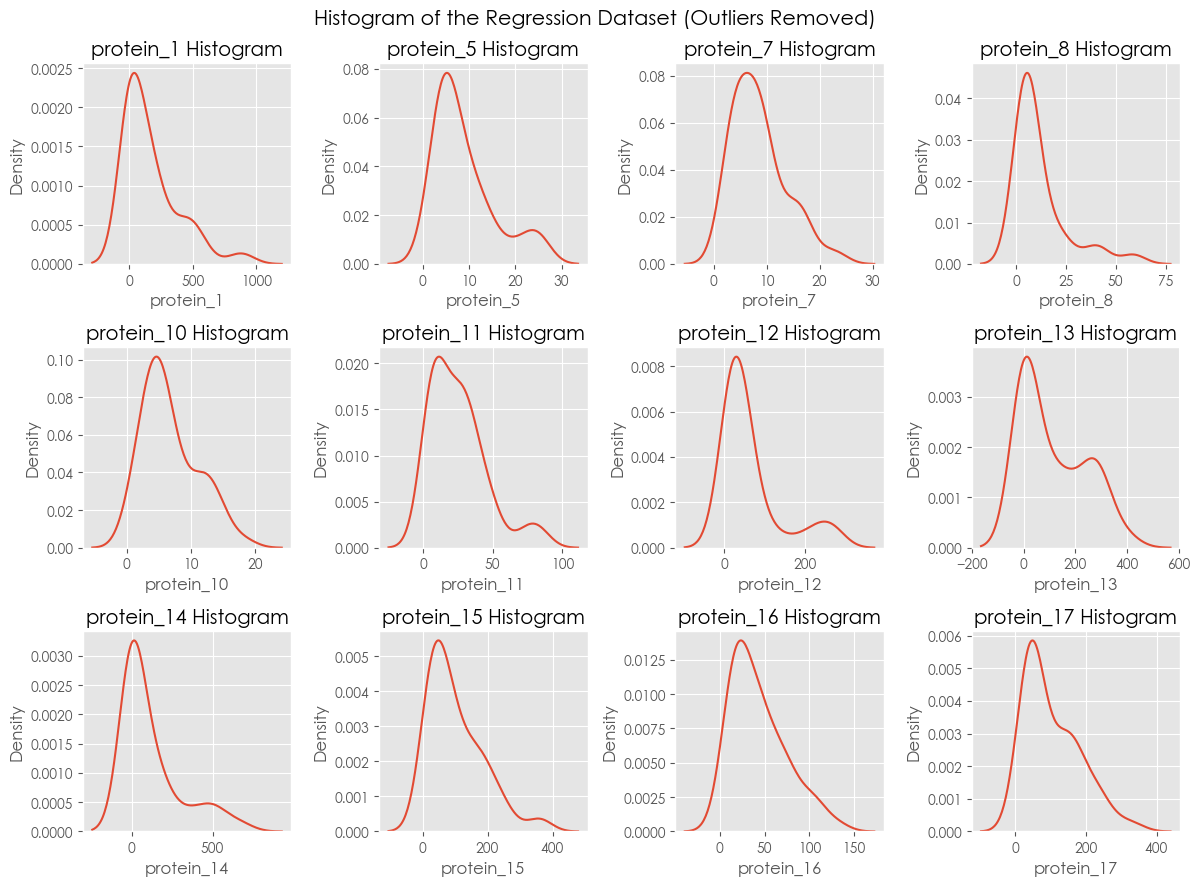

In [82]:
hist_reg_outlier_removed = pt.hist_all(reg_imp_outlier_removed, reg_num_var, 4, 3, title = 'Histogram of the Regression Dataset (Outliers Removed)')

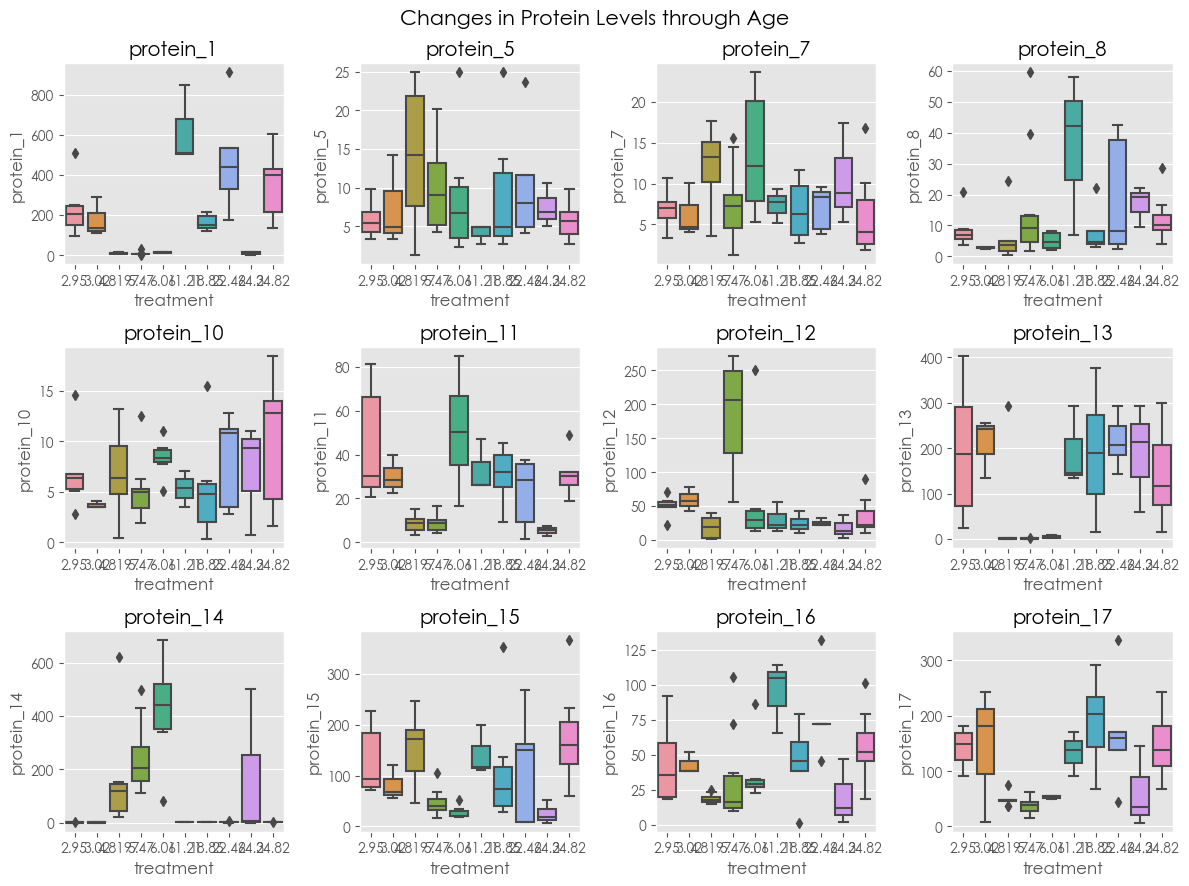

In [83]:
pt.test_all(reg_imp_outlier_removed, reg_num_var, 4 ,3, title = 'Changes in Protein Levels through Age')

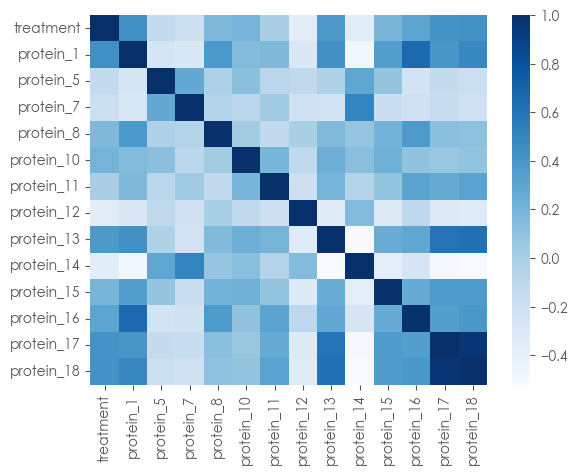

In [84]:
reg_corr_outliers_removed = reg_imp_outlier_removed.corr()
sns.heatmap(reg_corr_outliers_removed, cmap='Blues', annot=False);

Although there are 91 outliers using the Tukey's method of detection, for the modeling portion, we will use the full dataset (outlier included) in order to increase sample size and avoid overfitting. 

### 4.2.2 Regression Modeling

In [85]:
np.random.seed(42)
# splitting the data into X and y
X = reg_imp.reset_index().drop(['ID', 'treatment'], axis = 1)
y = reg_imp.reset_index()['treatment']

# creating a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# getting the shape of these newly created dataset
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 13), (31, 13), (124,), (31,))

In [86]:
X_train.head()

,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
96,2.13000,4.04,9.16,2.39,210.804865,163.055704,0.91,1.320000,52.61,236.78,283.8465,1462.116043,149.188867
122,5.67000,4.48,1.27,4.92,3.120000,10.560000,225.79,0.730000,236.80,56.64,16.1500,53.340000,6.150000
82,10.58000,1.28,0.85,25141.20,296.350000,6.400000,86.63,292.432643,0.65,18.41,24.7800,1114.910000,9.190000
109,7.19000,6.16,0.31,41.81,4.500000,4.000000,439.21,0.810000,315.25,142.19,16.9700,36.960000,5.530000
65,377.86507,4.55,0.28,3.41,4.180000,1.820000,0.22,124.530000,0.10,133.12,51.4600,1462.116043,21.190000


In [87]:
y_train.head()

96      8.29
122     5.47
82     18.90
109     5.47
65     24.30
Name: treatment, dtype: float64

### Creating our Pipeline
Here I will be creating a modeling pipeline with `ColumnTransformer` for scaling the dataframe

Recall we only have 1 type of columns: 
* `reg_num_var` : numerical datatype


In [91]:
# importing necessary libraries for regression testing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

# import metrics evaluators:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [92]:
# creating a dictionary of regression models to test
reg_models_dict = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'KNNR' : KNeighborsRegressor(),
    'SVR' : SVR(),
    'XGBoost': xg.XGBRegressor()
}

# creating a dictionary to keep the score of the model fit
model_score_dict_training_r2 = {}
model_score_dict_training_mae = {}
model_score_dict_training_mse = {}
model_cross_val_score = {}

for model_name, model in reg_models_dict.items():
    # creating a pipeline
    num_pipeline = Pipeline(steps=[
      ('scaler', StandardScaler())  
    ])

    # creating the column transformer
    column_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, reg_num_var)
    ])

    # creating the modeling pipeline
    model_pipeline = Pipeline(steps=[
        ('col_transformer', column_transformer),
        ('model', model)
    ])
    # fitting the model 
    rg_model = model_pipeline.fit(X_train, y_train)
    
    # getting the predicted y values
    y_preds = rg_model.predict(X_test)
    
    # populating the score dictionaries
    model_score_dict_training_r2[model_name] = r2_score(y_test, y_preds)
    model_score_dict_training_mse[model_name] = mean_squared_error(y_test, y_preds)
    model_score_dict_training_mae[model_name] = mean_absolute_error(y_test, y_preds)
    model_cross_val_score[model_name] = cross_val_score(model_pipeline, X, y, cv=5, scoring='r2')

In [93]:
model_cross_val_score

{'RandomForestRegressor': array([ -4.262404  , -31.81273575,  -0.81187687,  -1.01686963,
        -43.9950636 ]),
 'LinearRegression': array([ -84.33292049,  -50.35020971, -165.42519796,  -16.01288077,
        -133.16508001]),
 'KNNR': array([  -5.09788318,  -47.52772843,   -3.00830908,  -20.03534014,
        -149.37807235]),
 'SVR': array([  -1.12101925,  -58.88105361,   -4.72999678,  -14.9355831 ,
        -143.82899104]),
 'XGBoost': array([ -4.67096047, -36.09326422,  -0.45932377,  -2.67107914,
        -28.91350081])}

In [94]:
pd_model_training_r2 = pd.DataFrame(model_score_dict_training_r2.values(), 
                                    model_score_dict_training_r2.keys(), columns=['Training Score (R2)'])
pd_model_training_mse = pd.DataFrame(model_score_dict_training_mse.values(), 
                                    model_score_dict_training_mse.keys(), columns=['Training Score (MSE)'])
pd_model_training_mae = pd.DataFrame(model_score_dict_training_mae.values(), 
                                    model_score_dict_training_mae.keys(), columns=['Training Score (MAE)'])

u1 = pd_model_training_r2.join(pd_model_training_mse)
joined_initial_model_test = u1.join(pd_model_training_mae)
joined_initial_model_test.style.background_gradient(cmap='Blues')

,Training Score (R2),Training Score (MSE),Training Score (MAE)
RandomForestRegressor,0.643545,18.869619,2.525364
LinearRegression,-0.586746,83.997492,6.621152
KNNR,0.518440,25.492313,3.563057
SVR,0.076641,48.879823,5.347256
XGBoost,0.469554,28.080188,2.977314


It seems like the `RandomForestRegressor` outperformed other models in all the metrics evaluated. I will then use this model for hyperparameter tuning next. 

## 4.2.3 Hyperparameter Tuning of Random Forest Regressor

For this we will be using the `RandomizedSearchCV` function for testing various parameters

First I need to get the initial `best_params_` of the pre-hypertuned model

In [95]:
# creating a pipeline
num_pipeline = Pipeline(steps=[
      ('scaler', StandardScaler())  
    ])

# creating the column transformer
column_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, reg_num_var)
    ])

model_pipeline = Pipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', RandomForestRegressor())
])

rf_reg_model = model_pipeline.fit(X_train, y_train)

In [96]:
pd.DataFrame(rf_reg_model.named_steps['model'].get_params().values(), rf_reg_model.named_steps['model'].get_params().keys(), columns = ['Default Values'])

,Default Values
bootstrap,True
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


In [97]:
from sklearn.model_selection import RandomizedSearchCV

To use the Randomized Search method for optimizing the hyperparameters, we need to create a grid of these hyperparamter values to test

In [98]:
# experimenting with various param values
bootstrap = [True, False]
n_estimators = [int(x) for x in np.linspace(1, 1000, num = 500)]
max_features = ['sqrt', 'log2', None, 1.0]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_leaf = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2,3,4, 5,6,7,8,9,
                     10]
min_samples_leaf = [1, 2, 3, 4]

# creating the hyperparam values grid
rs_grid = {
    'model__bootstrap' : bootstrap,
    'model__n_estimators' : n_estimators,
    'model__max_features' : max_features,
    'model__max_depth' : max_depth,
    'model__max_leaf_nodes': max_leaf,
    'model__min_samples_split' : min_samples_split,
    'model__min_samples_leaf' : min_samples_leaf
    
}

In [99]:
rs_rf_reg_model = RandomizedSearchCV(model_pipeline,
                                    param_distributions=rs_grid,
                                    n_iter = 120,
                                    n_jobs = -1,
                                    cv = 5,
                                    verbose = True,
                                    random_state=42)

In [100]:
rs_rf_reg_model.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['protein_1', 'protein_5', 'protein_7', 'protein_8', 'protein_10',
       'protein_11', 'protein_12', 'protein_13', 'protein_14', 'protein_15',
       'protein_16', 'protein_17', 'protein_18'],
      dtype='object'))])),...
                                                             60, 70, 80, 90,
                                                             100, 110],
                                        'model__max_features': ['sqrt', 'log2',
                                                                None, 1.0],
                                        'model__max_leaf_nodes': [10, 20, 30,
                                                                  40, 50, 60,
                                                                  70, 80, 90,
                                                                  100, 110],
                                        'model__min_samples_leaf': [1, 2, 3, 4],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                                     6, 7, 8, 9,
                                                                     10],
                                        'model__n_estimators': [1, 3, 5, 7, 9,
                                                                11, 13, 15, 17,
                                                                19, 21, 23, 25,
                                                                27, 29, 31, 33,
                                                                35, 37, 39, 41,
                                                                43, 45, 47, 49,
                                                                51, 53, 55, 57,
                                                                59, ...]},
                   random_state=42, verbose=True)

In [101]:
rf_test_score = rf_reg_model.score(X_test, y_test)
rs_rf_test_score = rs_rf_reg_model.score(X_test, y_test)
print(f'With a initial  R2 score of {rf_test_score:.2f} and tuned score of {rs_rf_test_score:.2f} \nWhich means we get a {(rs_rf_test_score - rf_test_score)/rf_test_score * 100:.2f}% increase with a quick Hyperparameter tuning')

With a initial  R2 score of 0.62 and tuned score of 0.74 
Which means we get a 19.07% increase with a quick Hyperparameter tuning


In [102]:
rs_rf_reg_model.best_params_

{'model__n_estimators': 111,
 'model__min_samples_split': 3,
 'model__min_samples_leaf': 1,
 'model__max_leaf_nodes': 100,
 'model__max_features': 'log2',
 'model__max_depth': 80,
 'model__bootstrap': False}

### 4.2.4 Saving the model

In [103]:
dump(rs_rf_reg_model, 'rs_rf_reg_model_1.joblib')

['rs_rf_reg_model_1.joblib']

Testing the Model

In [110]:
test_array = [2,21,23,22,45,3,2,21,345,6,76,89, 20]

In [111]:
all_cols = reg_imp[reg_num_var].columns
all_cols

Index(['protein_1', 'protein_5', 'protein_7', 'protein_8', 'protein_10',
       'protein_11', 'protein_12', 'protein_13', 'protein_14', 'protein_15',
       'protein_16', 'protein_17', 'protein_18'],
      dtype='object')

In [112]:
test_df = pd.DataFrame(test_array, index=all_cols).T
test_df

,protein_1,protein_5,protein_7,protein_8,protein_10,protein_11,protein_12,protein_13,protein_14,protein_15,protein_16,protein_17,protein_18
0,2,21,23,22,45,3,2,21,345,6,76,89,20


In [117]:
predicted_age = rs_rf_reg_model.predict(test_df)[0]
print(f'The predicted age is {predicted_age:.2f} months!')

The predicted age is 15.47 months!


# 5. Summary <a name='summary'></a>

Next we look at the feature importances using the `.feature_importances_` attribute of the RandomForest model

## Importances Visualized for Classifer (Random Forest Classifier)

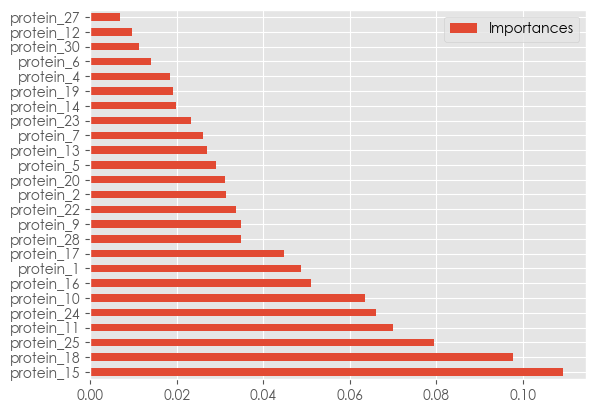

In [142]:
feat_import = pd.DataFrame(rs_rf_clf_model.best_estimator_.named_steps['model'].feature_importances_, index = X.columns, columns = ['Importances'])
feat_import.sort_values(by='Importances', ascending = False, inplace = True)
feat_import.plot(kind = 'barh');

## Importances Visualized for Regressor (Random Forest Regressor)

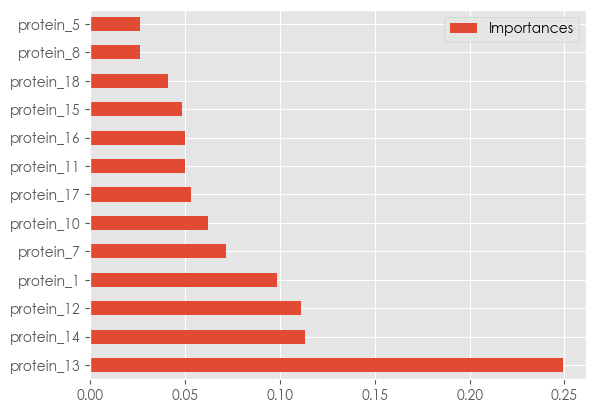

In [119]:
feat_import = pd.DataFrame(rs_rf_reg_model.best_estimator_.named_steps['model'].feature_importances_, index = X.columns, columns = ['Importances'])
feat_import.sort_values(by='Importances', ascending = False, inplace = True)
feat_import.plot(kind = 'barh');

For both of the two types of datasets, it seems like the RandomForest ensemble models worked the best. Because this is only a preliminary analyses with a truncated dataset, the accuracy and other evaluator metrics have a lower score. For the next study, it is imperative to increase sample size and experiment with feature selection.